# Explainable AI with Integrated Gradients

This notebook demonstrates how to apply **Integrated Gradients (IG)** to explain predictions made by a deep learning model trained for **sleep apnea detection** from physiological signals.

---

## What Are Integrated Gradients?

**Integrated Gradients** is a post-hoc explanation method that attributes the prediction of a neural network to its input features by integrating the model's gradients along a straight-line path from a **baseline input** (e.g., all zeros) to the actual input.

This method, introduced by Sundararajan et al. (2017), is particularly valued for satisfying two important axioms of attribution:

- **Sensitivity**: Features that influence the prediction receive non-zero attribution.
- **Implementation Invariance**: Functionally equivalent models yield the same attributions.

*Reference:*  
Sundararajan, M., Taly, A., & Yan, Q. (2017). *Axiomatic Attribution for Deep Networks*. Proceedings of the 34th International Conference on Machine Learning. [arXiv:1703.01365v2](https://arxiv.org/abs/1703.01365)

---

## Why Use IG for Sleep Apnea Detection?

In sleep medicine, explainable AI is increasingly important for building trust and aligning model decisions with clinical expectations. Sleep apnea detection models often process multichannel physiological data from **polysomnography (PSG)**, including SpO₂, heart rate, and respiratory signals.

While deep learning models perform well, they typically behave like black boxes. **Integrated Gradients** can help reveal which parts of the input contributed most to a prediction — such as **desaturation in SpO₂** or **abnormal thoracoabdominal effort** — making model behavior more interpretable to clinicians.

*Reference:*  
Zaschke, P., Maurer, M.C., et al. (2025). *A somnologist’s guide to explainable deep neural networks for sleep scoring*. **Somnologie**, 29, 85–92. https://doi.org/10.1007/s11818-025-00504-8

---

## Goals of This Notebook

-  Load a pretrained convolutional model for sleep apnea detection.
-  Apply the **Integrated Gradients** method to selected test windows.
-  Visualize which parts of the input signals contributed most to the model’s decisions.
-  Interpret the attribution maps in the context of physiological understanding.

---


## Step 1: Set Up Environment and Load Model

In this step, we:

- Import essential Python libraries:
  - `numpy` for numerical operations
  - `tensorflow` for loading and working with the Keras model
  - `matplotlib` for visualizations
  - `pyedflib` and `ElementTree` for parsing EDF and XML annotations
- Load the pretrained CNN model (`best_apnea_model.keras`) trained for **sleep apnea detection**.
- Print the model architecture using `model.summary()` to confirm successful loading.


In [210]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pyedflib
import xml.etree.ElementTree as ET
from pathlib import Path

# Load the pretrained model
model = tf.keras.models.load_model("best_apnea_model.keras")

# Display the model architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 60, 32)         │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 60, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 30, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 15, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 15, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,797 (522.65 KB)

 Trainable params: 44,449 (173.63 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 88,900 (347.27 KB)

## Step 2: Define Baseline and Sample Input

- We define a **baseline input**, which is required by Integrated Gradients. This baseline typically represents an "inactive" input — here, we use all zeros.
- We also create a dummy **example input**, which will later be replaced by real patient data (a PSG segment).
- Both the baseline and input are expanded to include a **batch dimension**, as required by TensorFlow models.


In [211]:
# Define a baseline input: all zeros with the same shape as a single sample
input_shape = (60, 4)  # 60 time steps, 4 channels
baseline = np.zeros(input_shape, dtype=np.float32)

# Create a dummy example input for testing
example_input = np.random.rand(*input_shape).astype(np.float32)

# Add batch dimension: shape becomes (1, 60, 4)
baseline = np.expand_dims(baseline, axis=0)
example_input = np.expand_dims(example_input, axis=0)

print("Baseline shape:", baseline.shape)
print("Input sample shape:", example_input.shape)


Baseline shape: (1, 60, 4)
Input sample shape: (1, 60, 4)


## Step 3: Define the Integrated Gradients Algorithm

Here we implement the Integrated Gradients (IG) method, based on Sundararajan et al. (2017):

1. **`interpolate_inputs()`** generates interpolated samples between the baseline and input.
2. **`compute_gradients()`** calculates the gradient of the model's output with respect to its inputs.
3. **`integrated_gradients()`**:
   - Interpolates between the baseline and input across multiple steps.
   - Averages the gradients at each step.
   - Multiplies the average gradient by the input difference to compute attributions.

This function returns the attributions of each feature (time, channel) for the model's decision.


In [212]:
@tf.function
def interpolate_inputs(baseline, input, steps=50):
    """
    Linearly interpolate between baseline and input across a number of steps.
    Returns: tensor of shape (steps+1, time, channels)
    """
    alphas = tf.linspace(0.0, 1.0, steps + 1)
    alphas = tf.cast(alphas, tf.float32)  # Match input dtype
    delta = input - baseline
    interpolated = baseline + alphas[:, tf.newaxis, tf.newaxis] * delta
    return interpolated

@tf.function
def compute_gradients(inputs, model):
    """
    Compute gradients of the model's output w.r.t the input.
    """
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        preds = model(inputs)
    return tape.gradient(preds, inputs)

def integrated_gradients(model, baseline, input, steps=50):
    """
    Full IG pipeline to compute attribution scores.
    """
    input = tf.convert_to_tensor(input[0:1], dtype=tf.float32)     # Ensure shape (1, time, channels)
    baseline = tf.convert_to_tensor(baseline[0:1], dtype=tf.float32)

    interpolated_inputs = interpolate_inputs(baseline, input, steps)
    grads = compute_gradients(interpolated_inputs, model)
    avg_grads = tf.reduce_mean(grads, axis=0)
    integrated_grads = (input - baseline)[0] * avg_grads

    return integrated_grads.numpy()  # Shape: (time, channels)


## Step 4: Compute and Visualize Feature Attributions (Dummy Input)

In this step:

- We apply the `integrated_gradients()` function to a **dummy input** using a zero baseline.
- The resulting attribution matrix quantifies how much each input feature (at each time step) contributed to the model’s prediction.
- We visualize the attribution map:
  - **X-axis** = time steps (e.g., seconds)
  - **Y-axis** = feature channels (e.g., SpO₂, pulse, thoracic effort, abdominal effort)
  - **Color** = importance score of the feature at that time point

> ⚠️ **Note:** This example uses randomly generated input data. It is only intended to verify that the Integrated Gradients implementation works as expected. Once we apply this to real PSG data, the attribution maps will highlight clinically relevant signal segments (e.g., SpO₂ desaturations or respiratory irregularities).


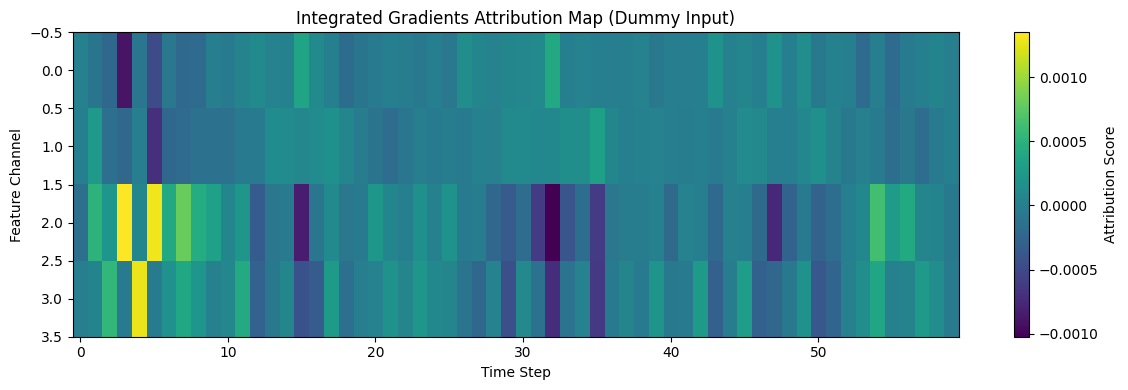

In [213]:
# Run Integrated Gradients on dummy input
attributions = integrated_gradients(model, baseline, example_input, steps=50)

# Visualize attributions
plt.figure(figsize=(12, 4))
plt.imshow(attributions.T, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label="Attribution Score")
plt.xlabel("Time Step")
plt.ylabel("Feature Channel")
plt.title("Integrated Gradients Attribution Map (Dummy Input)")
plt.tight_layout()
plt.show()


## Step 5: Match EDF and XML Files

We scan the `edf_data/` and `annotations/` directories for signal (EDF) and annotation (XML) files from the **SHHS2** dataset. Each file pair is matched by a unique subject ID.

Matched pairs will later be used to extract physiological signals (e.g., SpO₂, pulse) and sleep event annotations (e.g., apneas, hypopneas).


In [214]:
# Define folders
EDF_FOLDER = 'edf_data/'
ANNOT_FOLDER = 'annotations/'

# Get sorted lists of EDF and XML files
edf_files = sorted([f for f in os.listdir(EDF_FOLDER) if f.endswith('.edf')])
xml_files = sorted([f for f in os.listdir(ANNOT_FOLDER) if f.endswith('.xml')])

# Extract unique IDs from EDF filenames
edf_ids = {f.split('-')[1].split('.')[0] for f in edf_files}

# Match files by ID
edf_xml_pairs = [
    (os.path.join(EDF_FOLDER, f"shhs2-{id}.edf"),
     os.path.join(ANNOT_FOLDER, f"shhs2-{id}-nsrr.xml"))
    for id in edf_ids if f"shhs2-{id}-nsrr.xml" in xml_files
]

# Display results
print(f"✅ Matched {len(edf_xml_pairs)} EDF/XML pairs.")

# Optional preview of the first 5 pairs in a clean table
matched_df = pd.DataFrame(edf_xml_pairs, columns=["EDF File", "XML Annotation"])
display(matched_df.head())


✅ Matched 504 EDF/XML pairs.


EDF File                     XML Annotation
0  edf_data/shhs2-201099.edf  annotations/shhs2-201099-nsrr.xml
1  edf_data/shhs2-200693.edf  annotations/shhs2-200693-nsrr.xml
2  edf_data/shhs2-200923.edf  annotations/shhs2-200923-nsrr.xml
3  edf_data/shhs2-200699.edf  annotations/shhs2-200699-nsrr.xml
4  edf_data/shhs2-200984.edf  annotations/shhs2-200984-nsrr.xml

## Step 6: Extract Physiological Channels from EDF Files

This function extracts the following physiological signals from SHHS2 EDF recordings:

- **SpO₂** (oxygen saturation)
- **Pulse rate** (PR)
- **Thoracic effort** (`THOR RES`)
- **Abdominal effort** (`ABDO RES`)

The thoracic and abdominal signals are originally sampled at 8 Hz and are **downsampled to 1 Hz** to match the others for uniform temporal resolution.


In [232]:
def extract_signals_from_edf(edf_path):
    with pyedflib.EdfReader(edf_path) as f:
        label_map = {label.upper(): i for i, label in enumerate(f.getSignalLabels())}

        required_channels = {
            'SpO2': 'SAO2',
            'HR': 'PR',
            'Thoracic': 'THOR RES',
            'Abdominal': 'ABDO RES'
        }

        for ch in required_channels.values():
            if ch not in label_map:
                print(f"❌ Missing channel {ch} in {edf_path}")
                return None

        sao2 = f.readSignal(label_map['SAO2'])
        hr = f.readSignal(label_map['PR'])
        thor = f.readSignal(label_map['THOR RES'])
        abdo = f.readSignal(label_map['ABDO RES'])

        factor = 8
        thor_ds = thor[::factor]
        abdo_ds = abdo[::factor]

        min_len = min(len(sao2), len(hr), len(thor_ds), len(abdo_ds))
        data = np.stack([
            sao2[:min_len],
            hr[:min_len],
            thor_ds[:min_len],
            abdo_ds[:min_len]
        ], axis=1)

        return data

## Step 7: Parse Apnea Intervals from XML Annotations

This function extracts **apnea and hypopnea events** from SHHS2 annotation XML files. For each scored event, if it is labeled as "apnea" or "hypopnea", we extract:

- **Start time** (in seconds)
- **Duration** (in seconds)

The function then returns a list of `(start, end)` intervals representing disordered breathing events.


In [233]:
def extract_apnea_intervals(xml_path):
    """
    Extract (start, end) times of apnea or hypopnea events from an XML annotation file.
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    apnea_intervals = []

    for event in root.findall(".//ScoredEvent"):
        concept_elem = event.find("EventConcept")
        if concept_elem is None:
            continue

        concept = concept_elem.text.strip().lower()

        # Match any variant containing "apnea" or "hypopnea"
        if "apnea" in concept or "hypopnea" in concept:
            try:
                start = float(event.find("Start").text)
                duration = float(event.find("Duration").text)
                end = start + duration
                apnea_intervals.append((start, end))
            except (TypeError, ValueError):
                continue  # Skip malformed events

    return apnea_intervals


## Step 8: Segment Signals into 60-Second Windows

To prepare the data for classification, each physiological signal is segmented into **non-overlapping 60-second windows**.

- Each window is labeled as:
  - `1` (apnea): if it **overlaps** with any apnea or hypopnea interval.
  - `0` (non-apnea): if there is **no overlap** with any disordered breathing event.

This binary labeling enables the model to learn patterns indicative of apnea.


In [234]:
def create_windows_and_labels(signal_array, apnea_intervals, window_size=60):
    """
    Split signals into non-overlapping windows of `window_size` seconds.
    Label each window as apnea (1) if it overlaps any apnea/hypopnea event.
    """
    num_windows = signal_array.shape[0] // window_size
    X, y = [], []

    for i in range(num_windows):
        start_sec = i * window_size
        end_sec = start_sec + window_size

        window = signal_array[start_sec:end_sec]
        if window.shape[0] < window_size:
            continue  # skip incomplete windows

        # Assign label based on overlap with any apnea interval
        label = 0
        for apnea_start, apnea_end in apnea_intervals:
            if apnea_start < end_sec and apnea_end > start_sec:
                label = 1
                break

        X.append(window)
        y.append(label)

    return np.array(X), np.array(y)


## Step 9: Select 20 Random EDF/XML Pairs

To reduce runtime and complexity, we randomly select **20 matched EDF/XML pairs** from the dataset.

For each file pair:
- We extract multichannel physiological signals (SpO₂, PR, thoracic, abdominal).
- Parse apnea event annotations.
- Segment the data into 60-second windows and assign binary labels.

This subset will be used to evaluate **Integrated Gradients** explanations later.


In [244]:
import random

# Randomly pick 20 from matched pairs
random.seed(11)
sampled_pairs = random.sample(edf_xml_pairs, 20)

X_all, y_all = [], []

for edf_path, xml_path in sampled_pairs:
    print(f"🔄 Processing: {os.path.basename(edf_path)}")

    signals = extract_signals_from_edf(edf_path)
    if signals is None:
        continue

    apnea_intervals = extract_apnea_intervals(xml_path)
    X, y = create_windows_and_labels(signals, apnea_intervals)

    if len(X) == 0:
        continue

    X_all.append(X)
    y_all.append(y)

# Combine all windows into arrays
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

print(f"✅ Dataset from 20 EDFs: X = {X_all.shape}, y = {y_all.shape}")
print(f"Class distribution: {np.bincount(y_all)}")


🔄 Processing: shhs2-200705.edf
🔄 Processing: shhs2-200666.edf
🔄 Processing: shhs2-200745.edf
🔄 Processing: shhs2-200930.edf
🔄 Processing: shhs2-201250.edf
🔄 Processing: shhs2-201224.edf
🔄 Processing: shhs2-200998.edf
🔄 Processing: shhs2-200376.edf
🔄 Processing: shhs2-201212.edf
🔄 Processing: shhs2-200936.edf
🔄 Processing: shhs2-200994.edf
🔄 Processing: shhs2-200589.edf
🔄 Processing: shhs2-201020.edf
🔄 Processing: shhs2-200838.edf
🔄 Processing: shhs2-200818.edf
🔄 Processing: shhs2-201040.edf
🔄 Processing: shhs2-200829.edf
🔄 Processing: shhs2-200603.edf
🔄 Processing: shhs2-200859.edf
🔄 Processing: shhs2-200321.edf
🔄 Processing: shhs2-200782.edf
🔄 Processing: shhs2-200873.edf
🔄 Processing: shhs2-200762.edf
🔄 Processing: shhs2-200844.edf
🔄 Processing: shhs2-201219.edf
🔄 Processing: shhs2-200642.edf
🔄 Processing: shhs2-200997.edf
🔄 Processing: shhs2-200324.edf
🔄 Processing: shhs2-200790.edf
🔄 Processing: shhs2-200404.edf
🔄 Processing: shhs2-200524.edf
🔄 Processing: shhs2-200668.edf
🔄 Proces

## Step 10: Select 20 Random Windows for Explanation

Now that we have all windows from the 20 EDFs loaded in `X_all`,  
we randomly select **20 individual 60-second windows** to:

- Run predictions using the pretrained CNN model
- Interpret these predictions using **Integrated Gradients**

This small subset allows us to visually explore model behavior without overloading the notebook.


In [245]:
# Randomly sample 20 individual windows
np.random.seed(42)
selected_indices = np.random.choice(len(X_all), size=20, replace=False)

# Extract the corresponding inputs and labels
X_sample = X_all[selected_indices]
y_sample = y_all[selected_indices]

print(f"✅ Selected 20 windows for interpretation")
print(f"Shapes: X_sample = {X_sample.shape}, y_sample = {y_sample.shape}")
print(f"Label distribution: {np.bincount(y_sample)}")


✅ Selected 20 windows for interpretation
Shapes: X_sample = (50, 60, 4), y_sample = (50,)
Label distribution: [32 18]


## Run Model Predictions on Selected Samples

We use the pretrained CNN model to predict sleep apnea on the 20 randomly selected windows.

For each window:
- The model outputs a **probability** of the apnea class (1 = apnea, 0 = no apnea).
- We convert this probability to a **binary prediction** using a threshold of `0.5`.
- The results are printed alongside the ground truth for comparison.


In [247]:
# Predict probabilities for each window
y_pred_probs = model.predict(X_sample).flatten()

# Convert probabilities to binary predictions
y_pred_classes = (y_pred_probs >= 0.5).astype(int)

# Display predictions vs. ground truth
for i in range(len(X_sample)):
    print(f"Sample {i+1}: True={y_sample[i]}, Predicted={y_pred_probs[i]:.2f} → Class={y_pred_classes[i]}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Sample 1: True=1, Predicted=0.78 → Class=1
Sample 2: True=1, Predicted=0.13 → Class=0
Sample 3: True=0, Predicted=0.71 → Class=1
Sample 4: True=0, Predicted=0.86 → Class=1
Sample 5: True=1, Predicted=0.82 → Class=1
Sample 6: True=0, Predicted=0.89 → Class=1
Sample 7: True=0, Predicted=0.45 → Class=0
Sample 8: True=1, Predicted=0.86 → Class=1
Sample 9: True=0, Predicted=0.31 → Class=0
Sample 10: True=0, Predicted=0.00 → Class=0
Sample 11: True=0, Predicted=0.27 → Class=0
Sample 12: True=1, Predicted=0.56 → Class=1
Sample 13: True=0, Predicted=0.04 → Class=0
Sample 14: True=1, Predicted=0.84 → Class=1
Sample 15: True=1, Predicted=0.86 → Class=1
Sample 16: True=1, Predicted=0.97 → Class=1
Sample 17: True=0, Predicted=0.46 → Class=0
Sample 18: True=1, Predicted=0.93 → Class=1
Sample 19: True=0, Predicted=0.25 → Class=0
Sample 20: True=1, Predicted=0.80 → Class=1
Sample 21: True=0, Predicted=0.23 → Class=0
Sample 22: True=0, Predicted=0.01 → Class=0
Sam

## Attribution-Based Model Interpretation Using Integrated Gradients

To understand the internal decision-making process of the trained CNN model, we employ the **Integrated Gradients (IG)** method to estimate feature attributions across time and signal modalities.

For each of the 20 previously selected test windows, we compute an attribution matrix that quantifies the contribution of each input feature (i.e., physiological signal at a specific time step) to the model's output.

The resulting visualizations:
- Allow for fine-grained temporal localization of salient features,
- Facilitate comparison across **true positive**, **true negative**, **false positive**, and **false negative** predictions,
- Support interpretability by linking model decisions to clinically relevant signal patterns, such as **desaturations in SpO₂** or **irregular thoracoabdominal effort**.

Each heatmap below displays:
- **X-axis**: 60 time steps (seconds),
- **Y-axis**: 4 physiological channels (SpO₂, PR, Thoracic, Abdominal),
- **Color scale**: Attribution magnitude, where bright yellow indicates high positive attribution (strong contribution to predicted class), and dark purple indicates negative attribution.


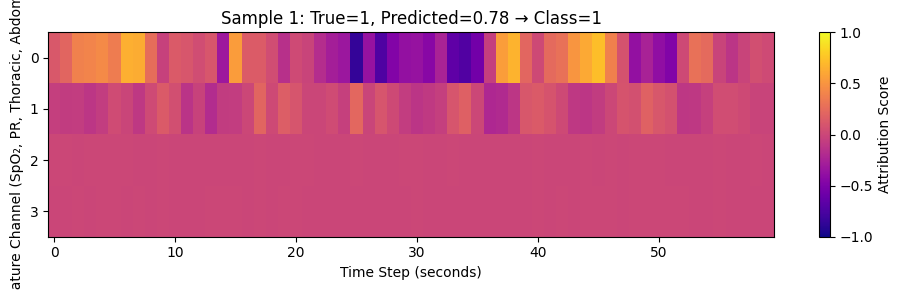

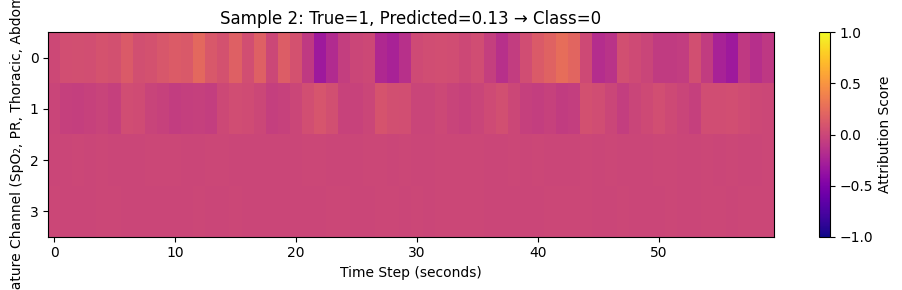

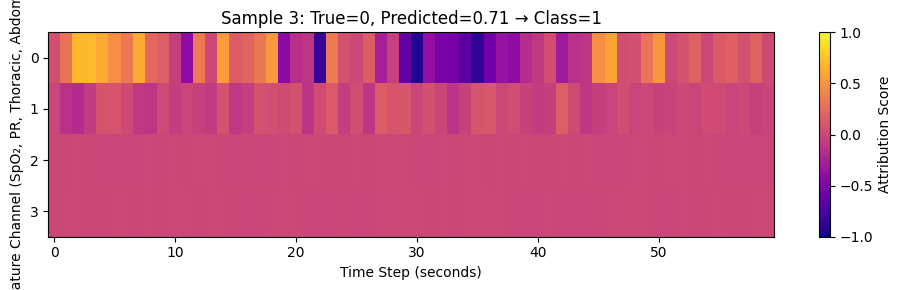

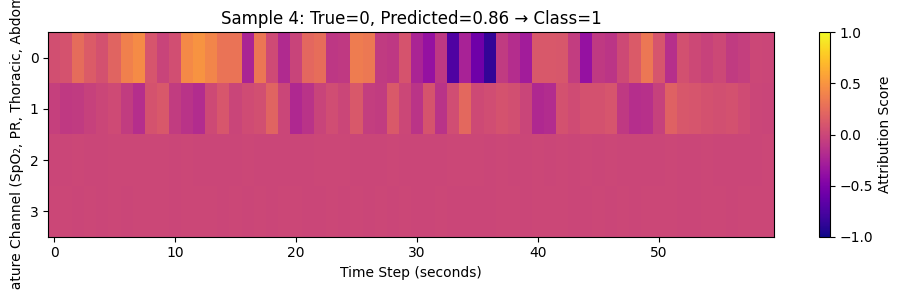

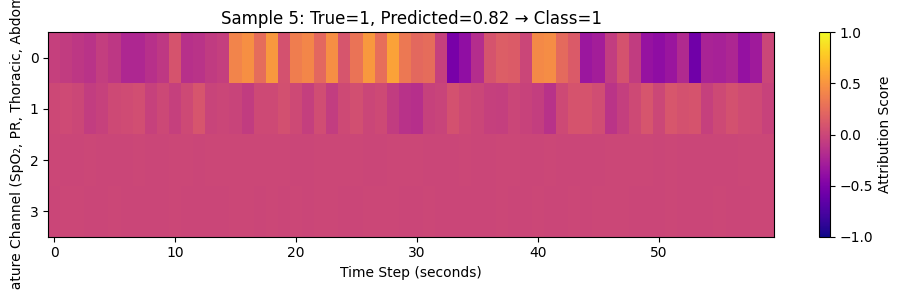

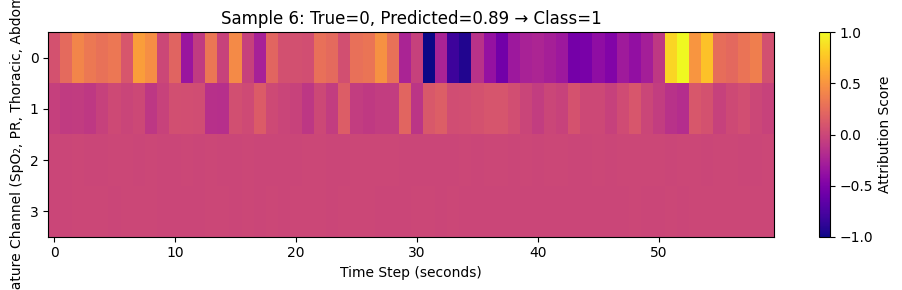

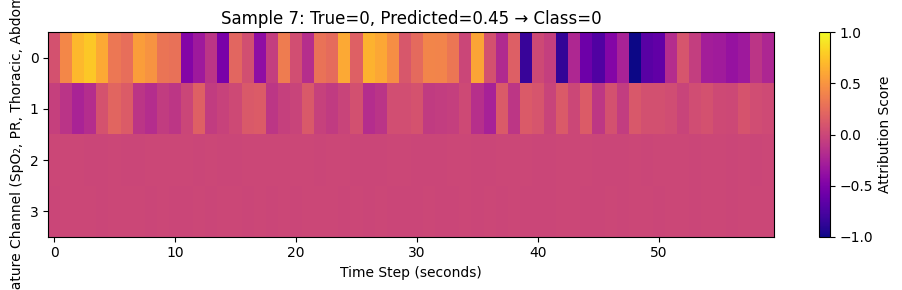

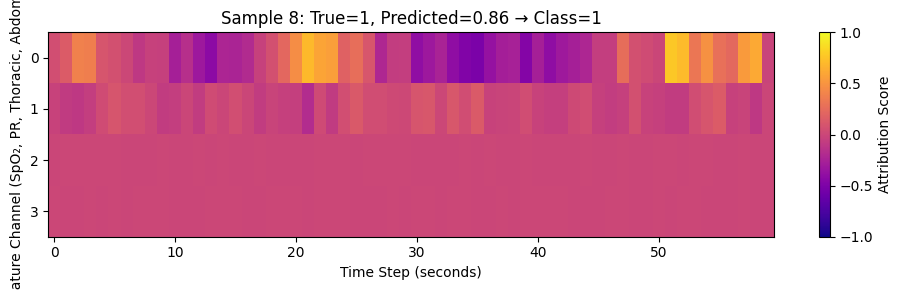

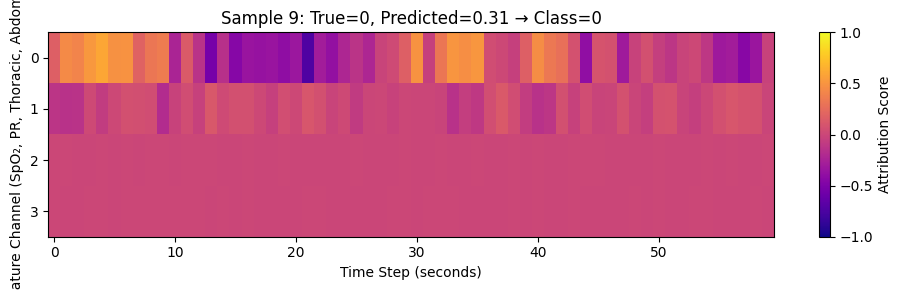

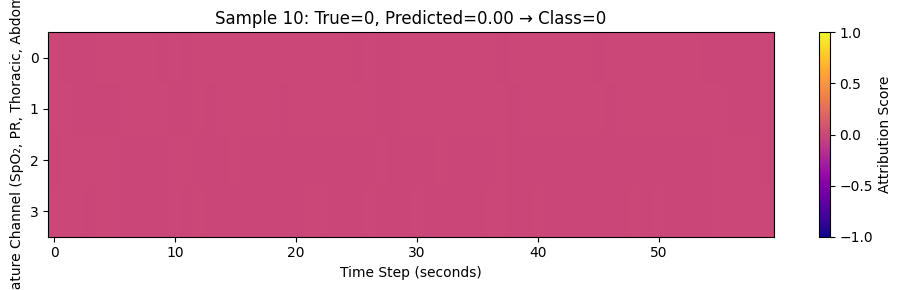

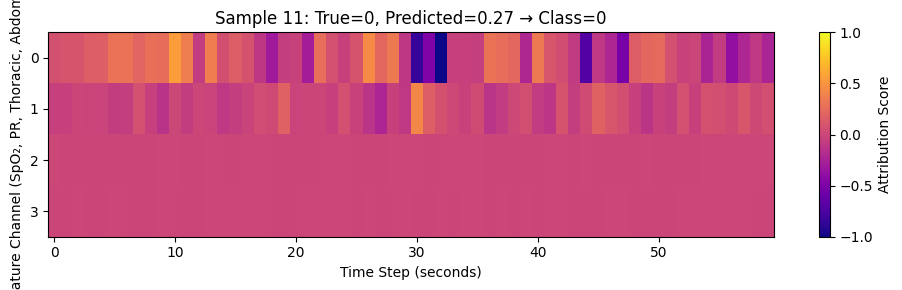

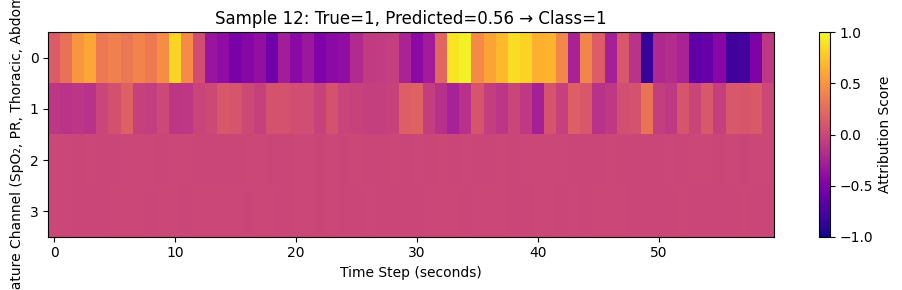

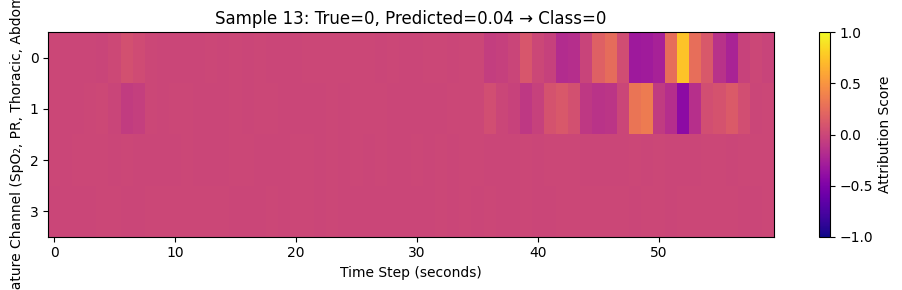

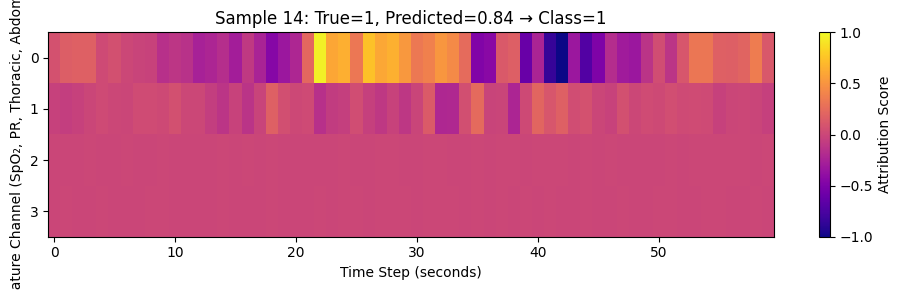

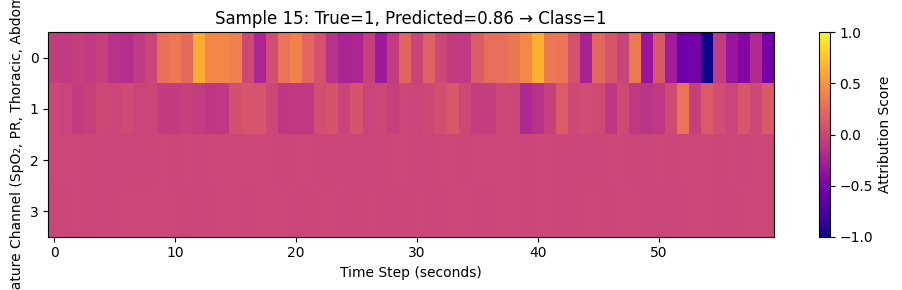

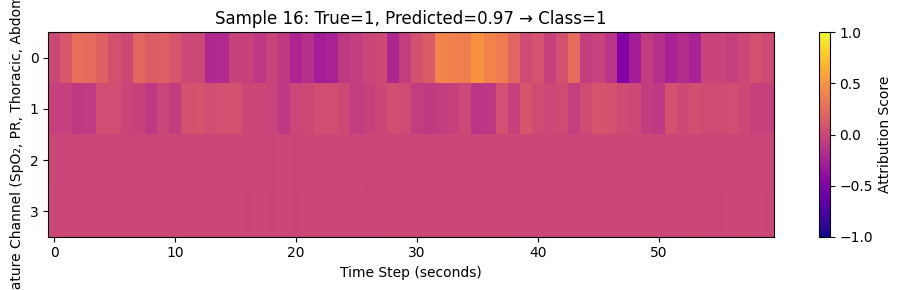

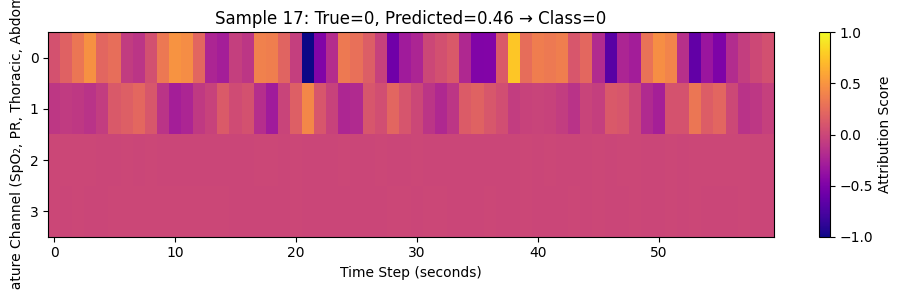

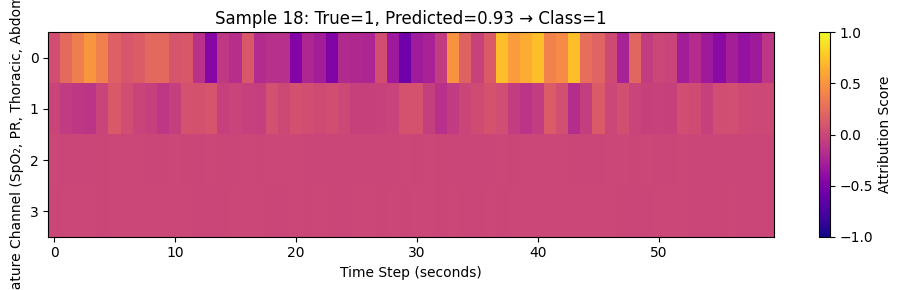

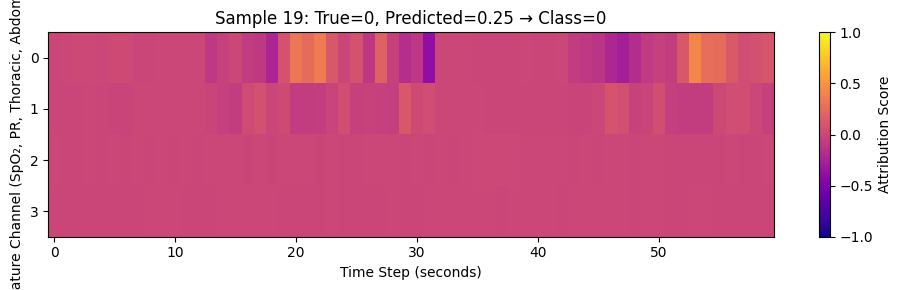

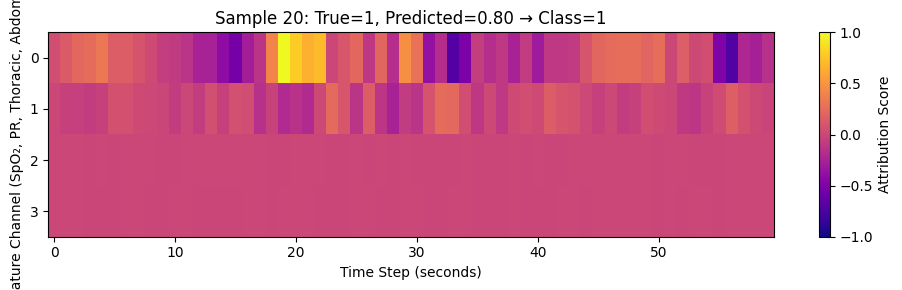

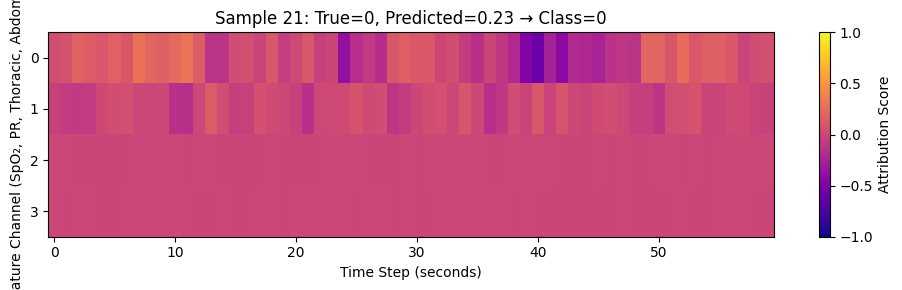

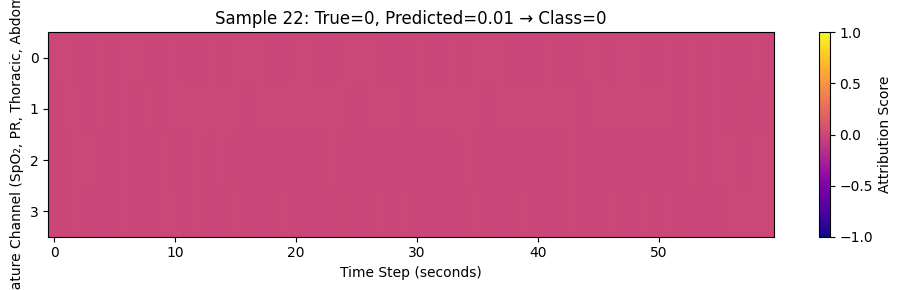

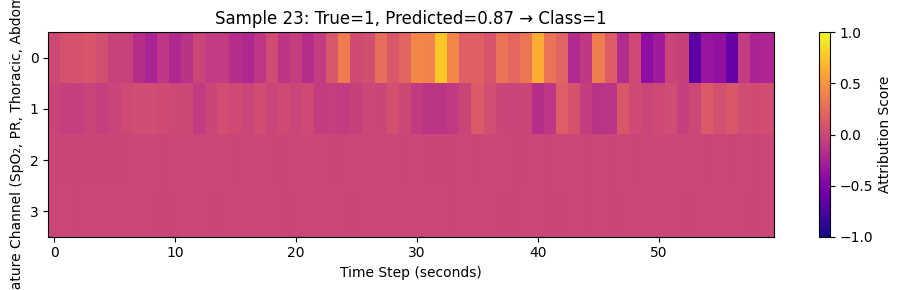

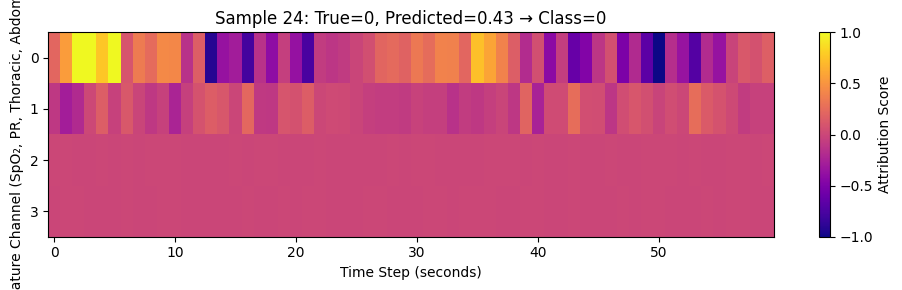

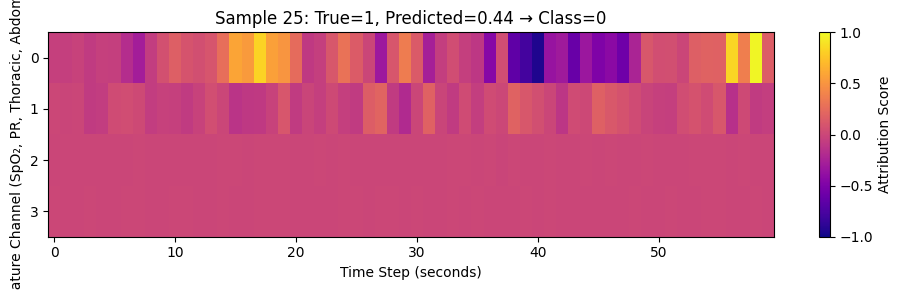

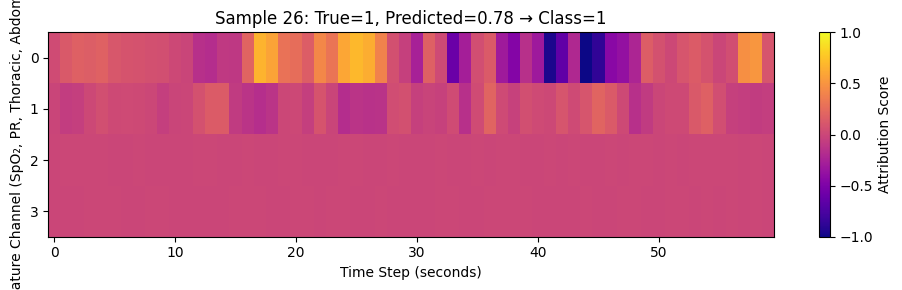

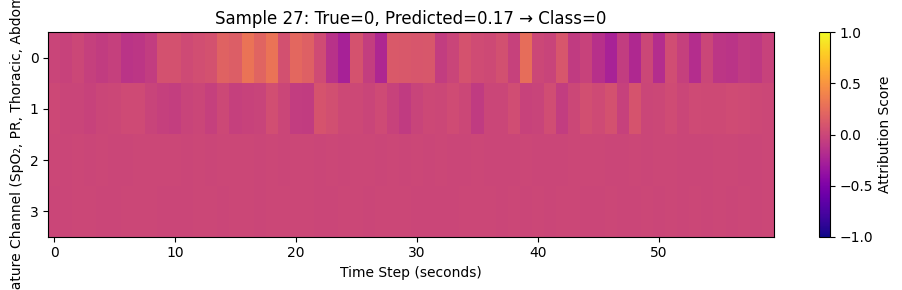

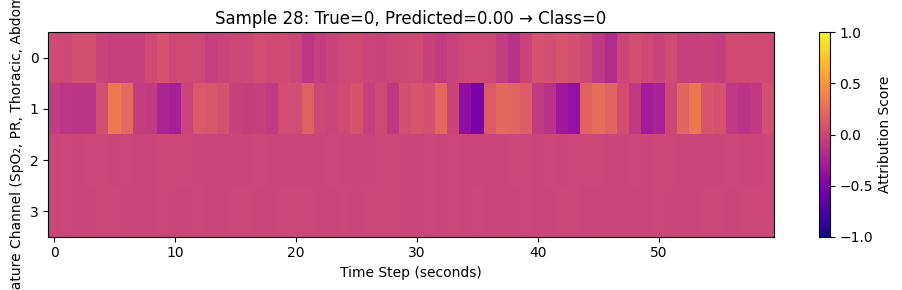

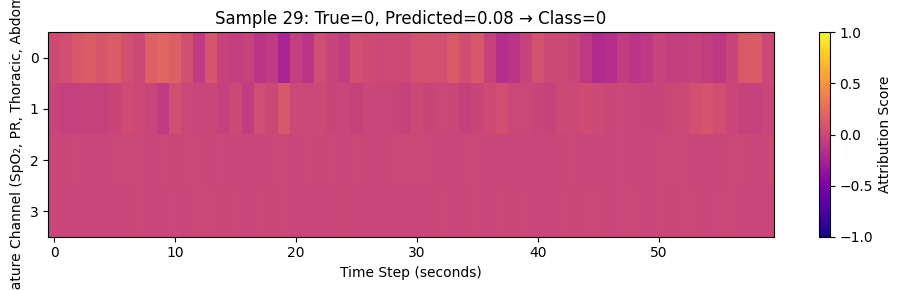

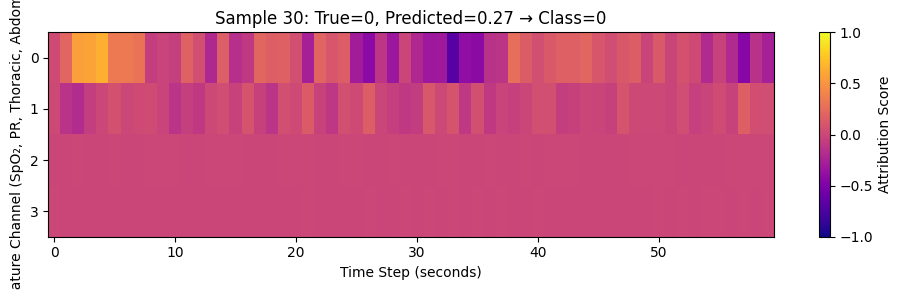

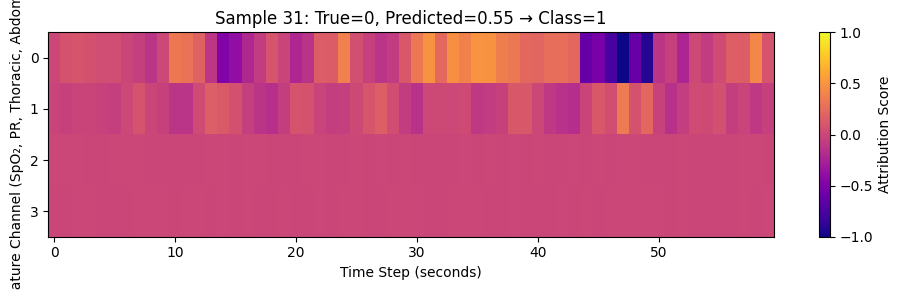

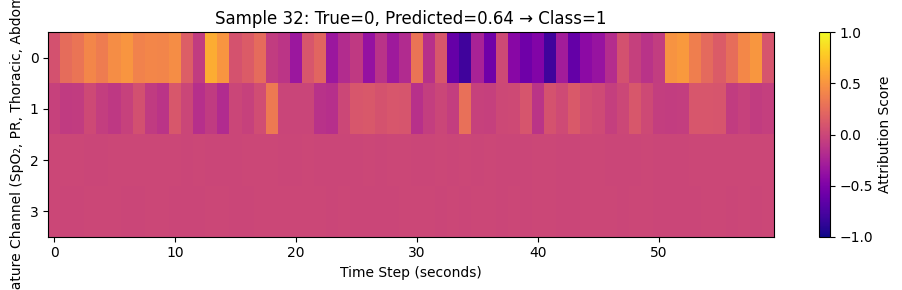

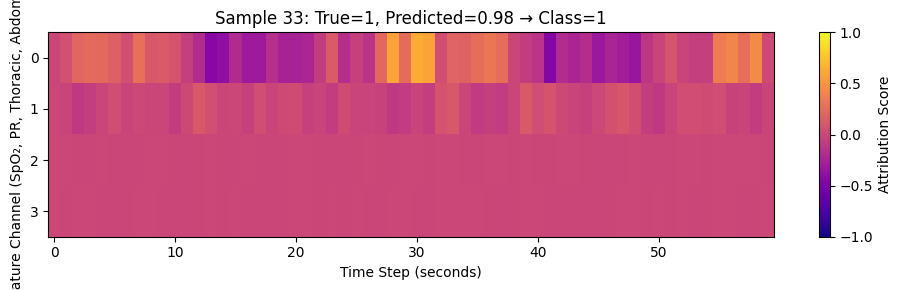

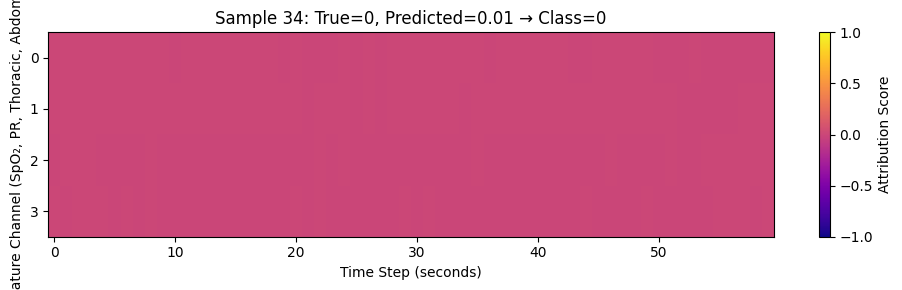

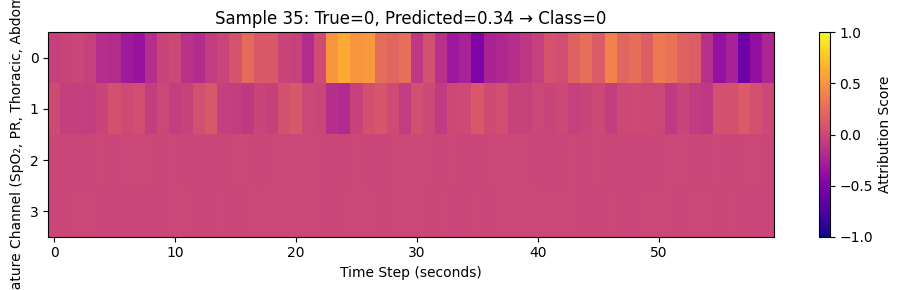

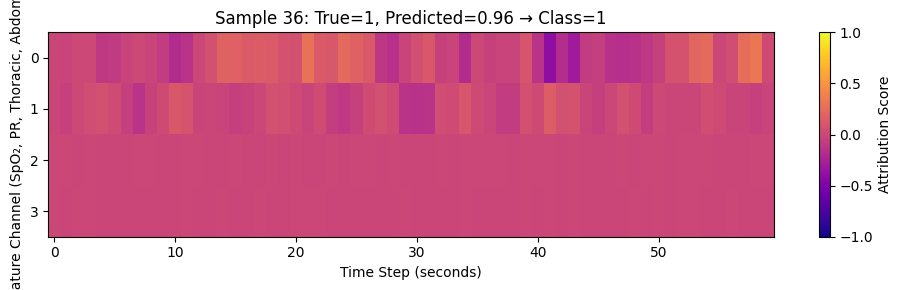

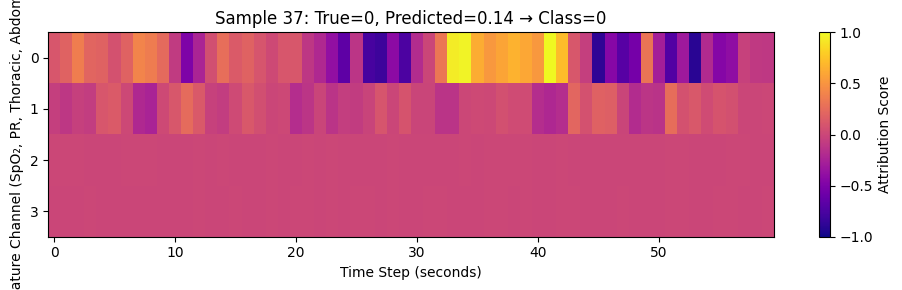

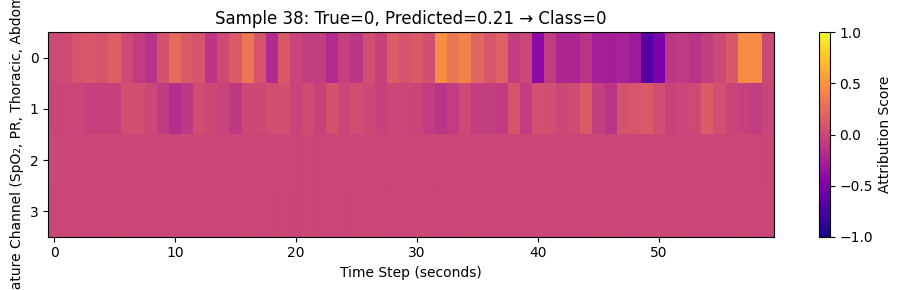

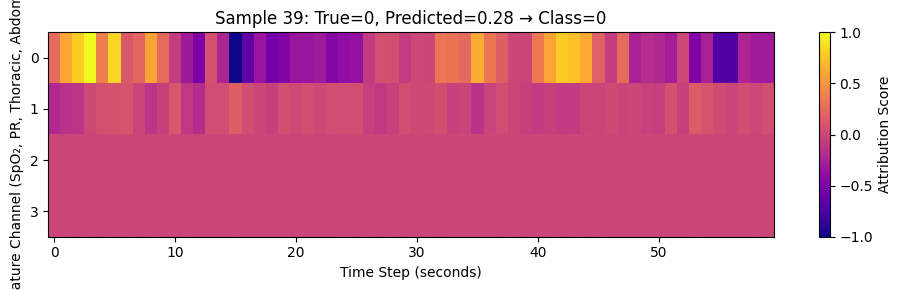

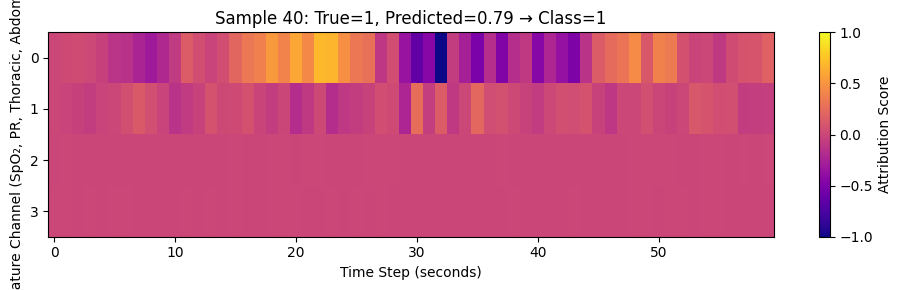

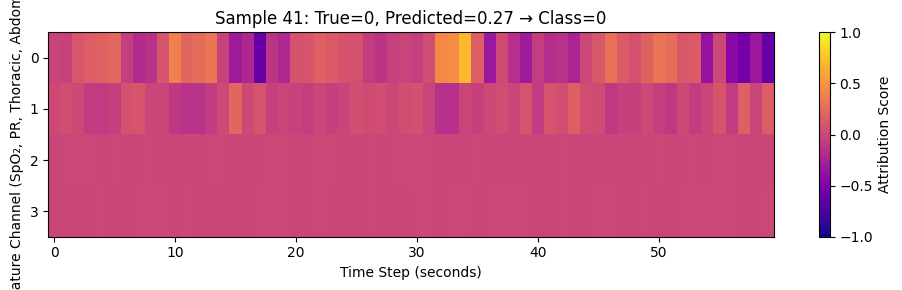

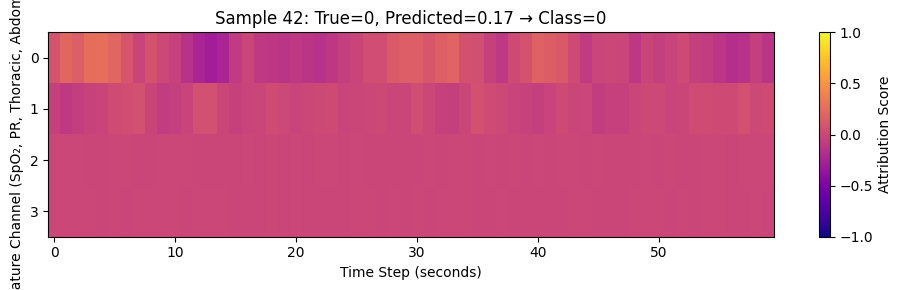

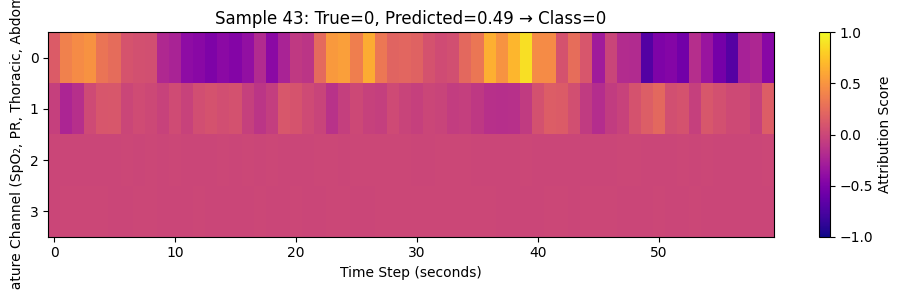

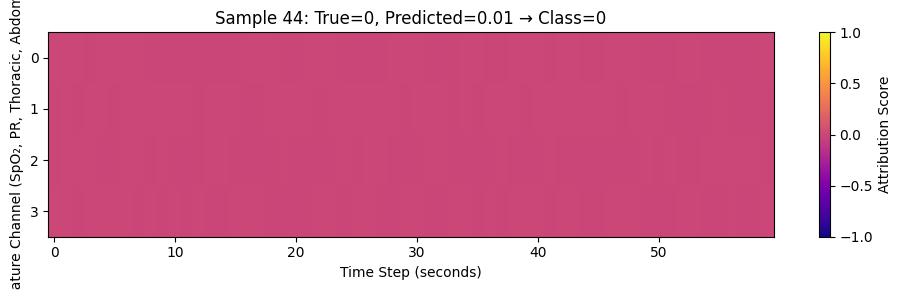

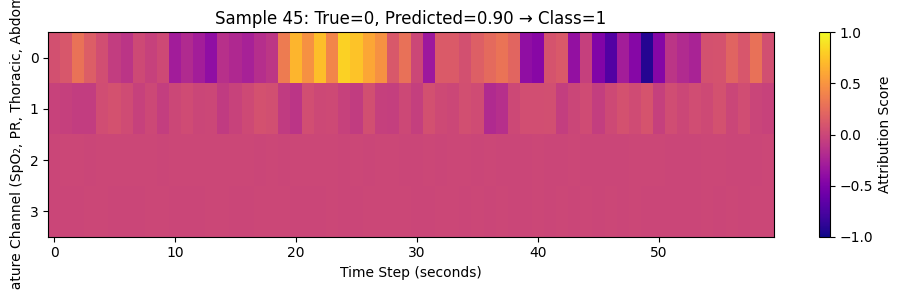

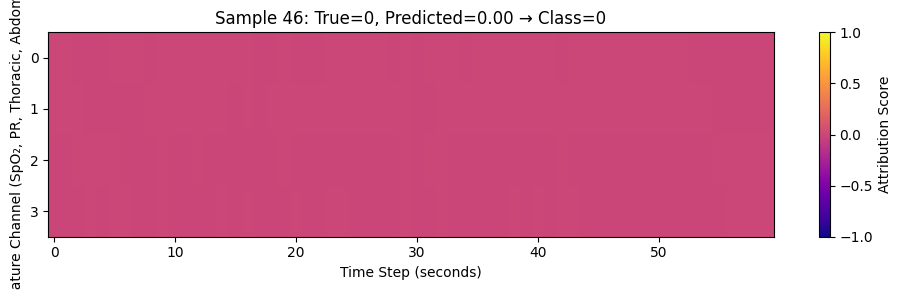

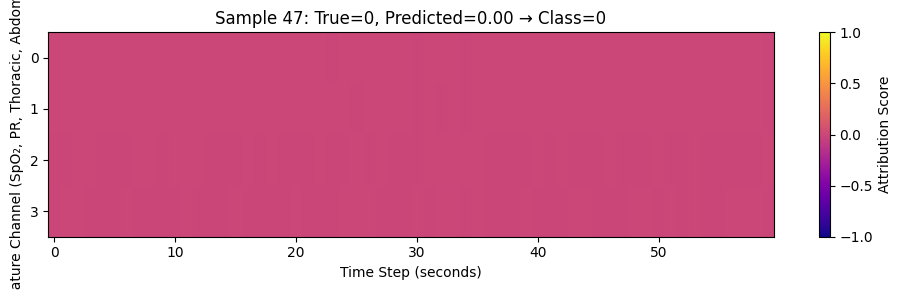

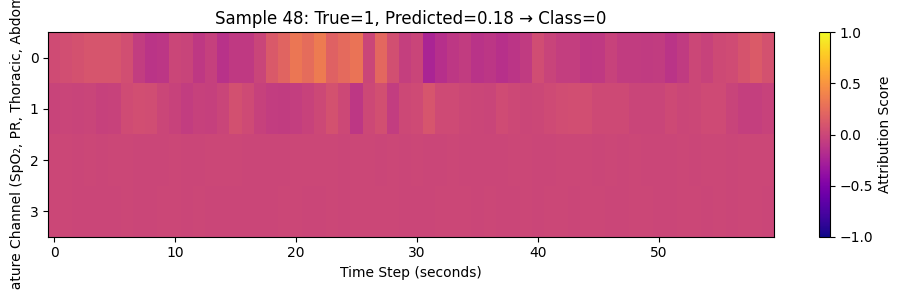

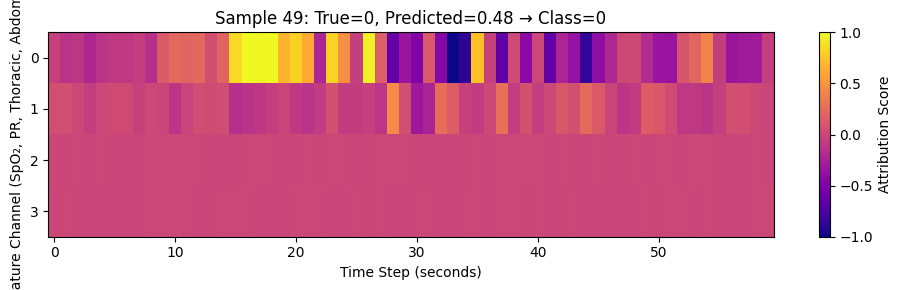

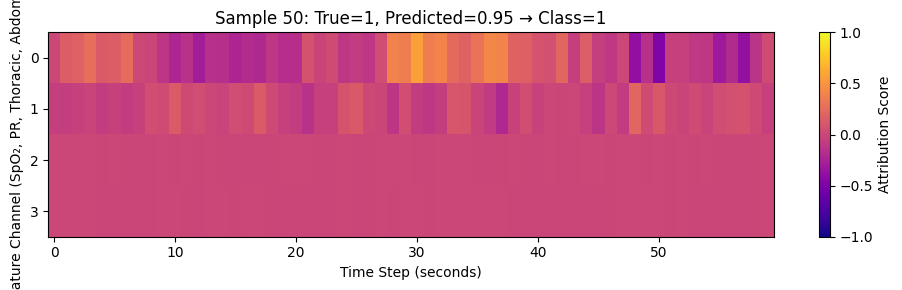

In [248]:
# Define global color scale limits for consistency
vmin, vmax = -1, 1

for i in range(len(X_sample)):
    x = X_sample[i:i+1]  # Input shape: (1, 60, 4)
    true_label = y_sample[i]
    pred_prob = y_pred_probs[i]
    pred_class = y_pred_classes[i]

    # Use zero baseline for Integrated Gradients
    baseline = np.zeros_like(x)

    # Compute attribution scores using IG
    attributions = integrated_gradients(model, baseline, x, steps=50)  # shape: (60, 4)

    # Plot attribution heatmap
    plt.figure(figsize=(10, 3))
    plt.imshow(
        attributions.T,                  # shape: (4, 60)
        aspect='auto',
        cmap='plasma',
        interpolation='nearest',
        vmin=vmin,
        vmax=vmax
    )
    plt.colorbar(label="Attribution Score")
    plt.title(f"Sample {i+1}: True={true_label}, Predicted={pred_prob:.2f} → Class={pred_class}", fontsize=12)
    plt.xlabel("Time Step (seconds)")
    plt.ylabel("Feature Channel (SpO₂, PR, Thoracic, Abdominal)")
    plt.tight_layout()
    plt.show()


### Interpreting Attribution Maps with a Unified Color Scale

To ensure visual comparability across samples, we applied a **fixed global color scale** to all attribution maps generated by Integrated Gradients.

- **Color Interpretation (using `plasma` colormap)**:
  - **Bright yellow** ≈ **+1.0** → Strong **positive attribution**  
    (feature strongly pushes the model toward predicting **apnea**)
  - **Orange** ≈ **+0.5** → Moderate positive influence
  - **Light magenta/pink** ≈ **0.0** → **Neutral**  
    (feature has little to no influence)
  - **Purple** ≈ **–0.5** → Moderate **negative attribution**
  - **Dark blue** ≈ **–1.0** → Strong **negative attribution**  
    (feature pushes model away from apnea)

- **Axes**:
  - **X-axis**: Time steps across the 60-second input window  
  - **Y-axis**: Input feature channels:  
    - `0 = SpO₂` (Oxygen Saturation)  
    - `1 = PR` (Pulse Rate)  
    - `2 = Thoracic Respiration`  
    - `3 = Abdominal Respiration`

- **Interpretation Guidelines**:
  - Yellow/orange regions highlight features that promoted apnea classification.
  - Purple/blue regions indicate features that discouraged apnea predictions (supporting **normal**).
  - Pinkish tones (near 0) mark signals that were largely ignored by the model.
  - ❗ **Misclassifications** may show high attribution in clinically implausible regions — pointing to model uncertainty or bias.

By fixing the color scale (`vmin = -1`, `vmax = 1`), we ensure that all heatmaps share a common interpretive framework, making visual differences meaningful and scientifically comparable.


### Quantifying Feature Importance Across Samples

While attribution heatmaps provide detailed insight into individual predictions, it's also important to summarize **overall feature importance** across the dataset.

In this step:

- We compute the **mean absolute attribution** per channel using Integrated Gradients.
- Attributions are grouped by **correctly predicted samples**:
  - True Positives (`True = 1`, `Pred = 1`)
  - True Negatives (`True = 0`, `Pred = 0`)
- This comparison helps quantify which physiological channels (e.g., **SpO₂**, **Pulse Rate**) the model relies on most when identifying apnea vs. normal breathing.

#### Interpretation:
- Higher values indicate that the model consistently attributes importance to that channel for the corresponding class.
- For example, if **SpO₂** shows high attribution in apnea predictions, it suggests the model uses desaturation patterns as key indicators.



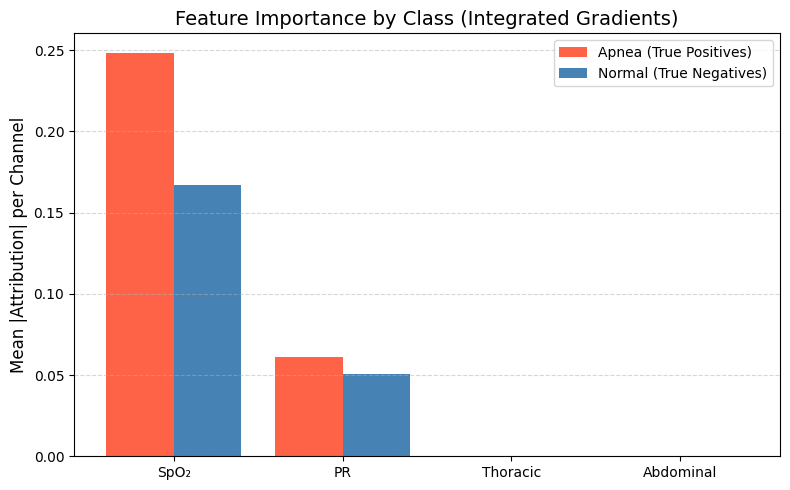

In [249]:
# --- Compute IG attributions for all selected samples ---
all_attributions = []
for i in range(len(X_sample)):
    x = X_sample[i:i+1]  # shape: (1, 60, 4)
    baseline = np.zeros_like(x)
    attr = integrated_gradients(model, baseline, x, steps=50)
    all_attributions.append(attr)  # shape: (60, 4)

# --- Group by correctly predicted class ---
correct_apnea_attr = [
    attr for i, attr in enumerate(all_attributions)
    if y_sample[i] == 1 and y_pred_classes[i] == 1
]
correct_normal_attr = [
    attr for i, attr in enumerate(all_attributions)
    if y_sample[i] == 0 and y_pred_classes[i] == 0
]

# --- Compute per-channel average attribution magnitude ---
def compute_mean_abs_attribution(attribution_list):
    """Returns mean absolute attribution per channel averaged across samples."""
    return np.mean([np.abs(attr).mean(axis=0) for attr in attribution_list], axis=0)

mean_apnea = compute_mean_abs_attribution(correct_apnea_attr)
mean_normal = compute_mean_abs_attribution(correct_normal_attr)

# --- Plot feature importance ---
channels = ['SpO₂', 'PR', 'Thoracic', 'Abdominal']
x_pos = np.arange(len(channels))

plt.figure(figsize=(8, 5))
plt.bar(x_pos - 0.2, mean_apnea, width=0.4, label='Apnea (True Positives)', color='tomato')
plt.bar(x_pos + 0.2, mean_normal, width=0.4, label='Normal (True Negatives)', color='steelblue')

plt.xticks(x_pos, channels)
plt.ylabel("Mean |Attribution| per Channel", fontsize=12)
plt.title("Feature Importance by Class (Integrated Gradients)", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Interpretation of Feature Importance by Class (Integrated Gradients)

This chart summarizes the **mean absolute attribution per channel** across correctly predicted samples using the Integrated Gradients method. The goal is to quantify which input signals the model relied on most for its predictions.

#### Key Insights:

- **SpO₂ (Oxygen Saturation)**  
  - Shows the **highest attribution** for both apnea (`True Positive`) and normal (`True Negative`) samples.
  - The model consistently relies on SpO₂ patterns, particularly **desaturation events**, when identifying apnea episodes.
  - This aligns well with clinical understanding, where oxygen drops are key indicators of sleep apnea.

- **Pulse Rate (PR)**  
  - Shows moderate attribution, especially during apnea segments.
  - Reflects the model’s ability to capture **heart rate fluctuations** associated with autonomic responses to apnea.

- **Thoracic and Abdominal Effort**  
  - Exhibit **minimal attribution** across both classes.
  - Potential reasons:
    - These channels may have lower signal quality or variability.
    - The model architecture or training process might have biased learning toward SpO₂ and PR.
    - Downsampling from 8 Hz to 1 Hz could have reduced the discriminative power of respiratory effort signals.

#### Conclusion:

> The model’s decisions are primarily driven by SpO₂ and, to a lesser extent, PR. Respiratory effort signals (thoracic and abdominal) appear underutilized, which could be a limitation of the current model or preprocessing pipeline.

This analysis provides both **scientific insight** and a basis for future model refinement or clinical validation.


### Signal and Attribution Alignment for SpO₂ and PR

To better understand how the model leverages the two most influential features—**oxygen saturation (SpO₂)** and **pulse rate (PR)**—we visualize the raw signals alongside their corresponding **Integrated Gradients (IG)** attribution maps for each of the 20 analyzed windows.

For each window:
- The **top plot** shows the raw SpO₂ signal over a 60-second segment.
- The **middle plot** displays the corresponding PR signal for the same interval.
- The **bottom heatmap** shows IG attributions for SpO₂ and PR over time:
  - **X-axis** = Time in seconds (sampled at 1 Hz)
  - **Y-axis** = Feature channels: 0 = SpO₂, 1 = PR
  - **Color** = Attribution score from IG (using a fixed scale of −1 to +1)

#### Interpretation Objectives:
- Regions in **bright yellow** indicate strong positive attribution, suggesting that a signal fluctuation in that time frame contributed to a **higher predicted probability of apnea**.
- **Purple/blue** regions reflect features that **discouraged** an apnea prediction.
- This alignment allows us to visually **correlate physiological signal changes** (e.g., desaturation events or heart rate drops) with the model’s internal reasoning.

By comparing these three layers (signal, signal, attribution), we gain clearer insight into how the model interprets low-level physiological patterns and which time steps are deemed critical for its decision.


/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


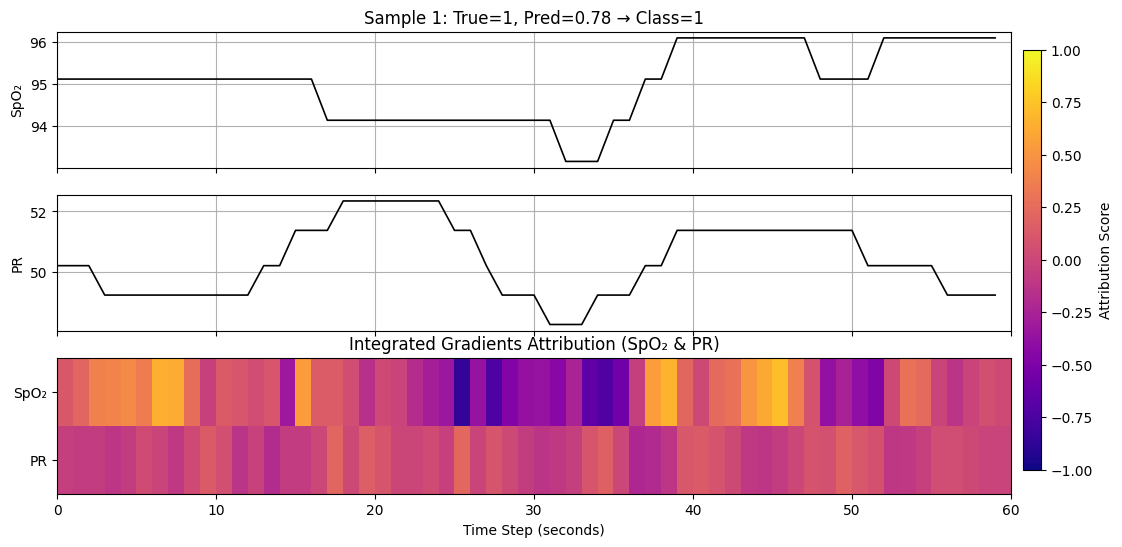

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


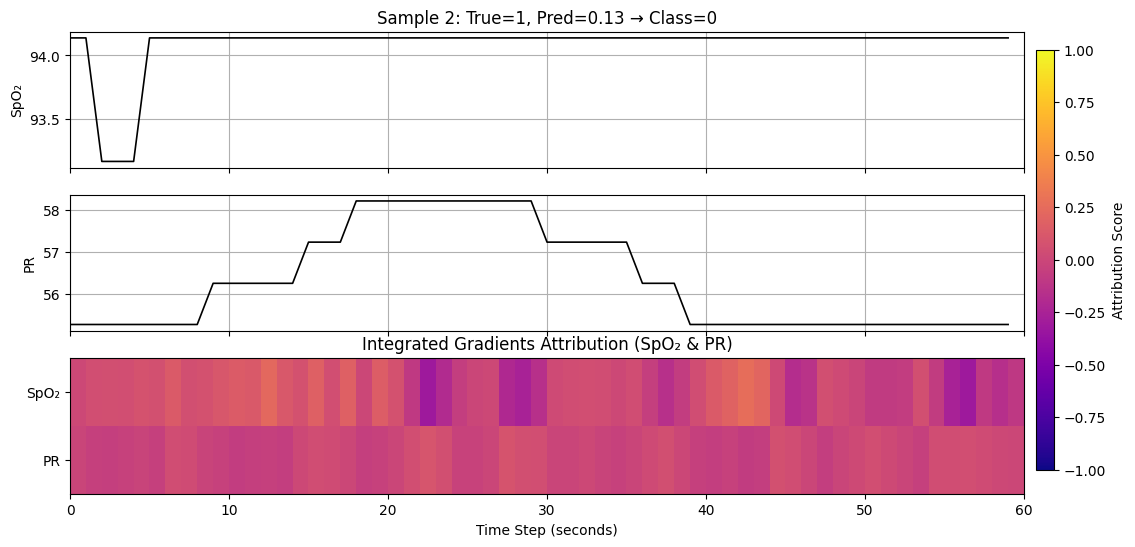

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


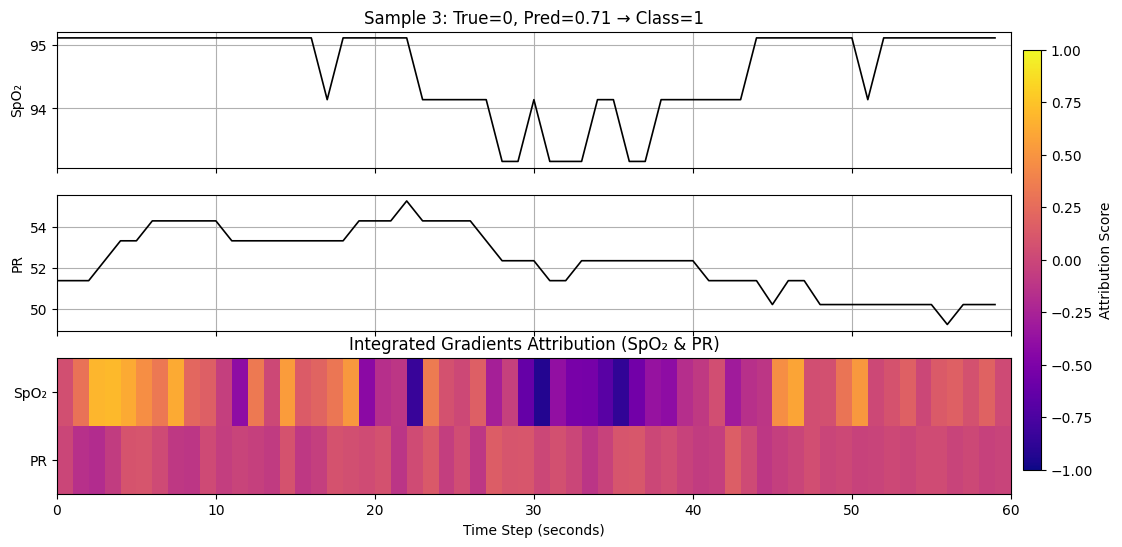

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


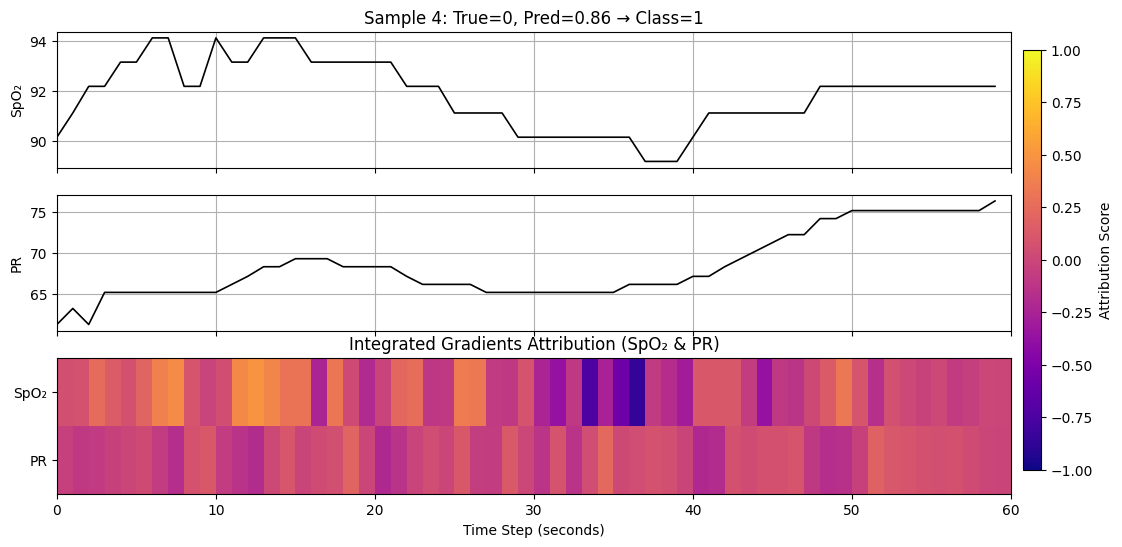

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


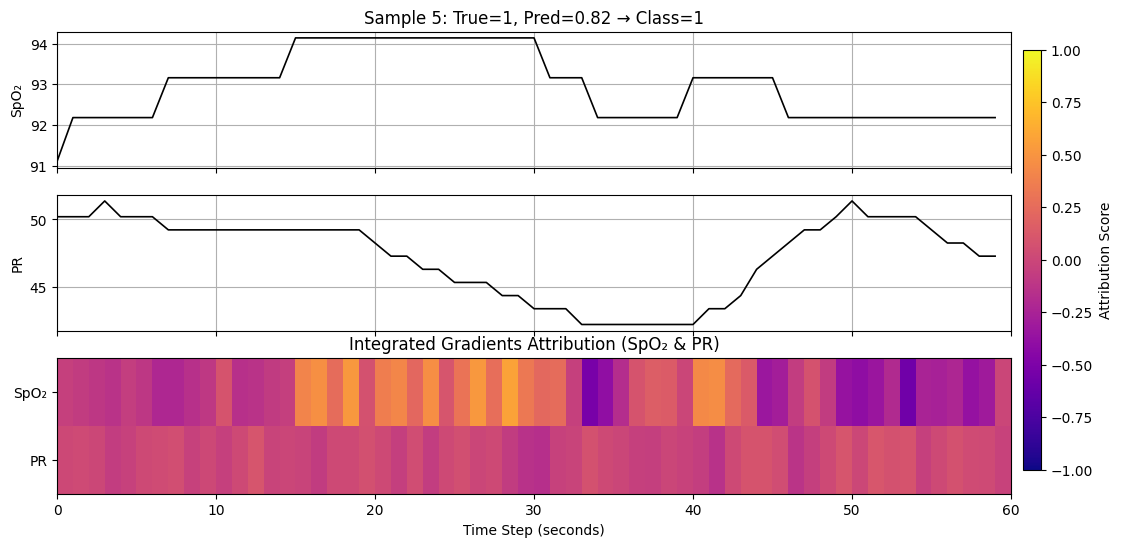

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


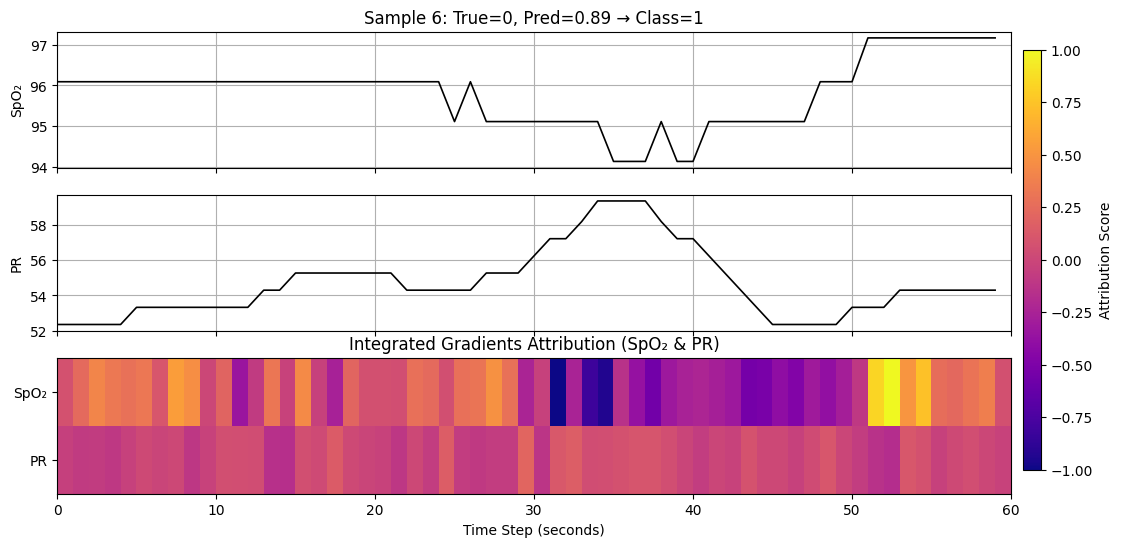

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


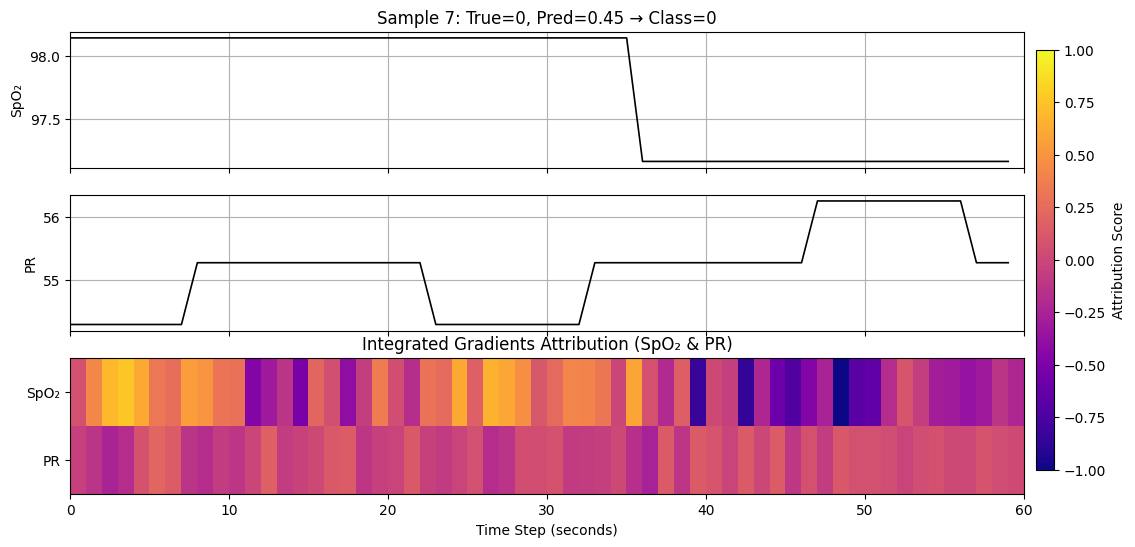

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


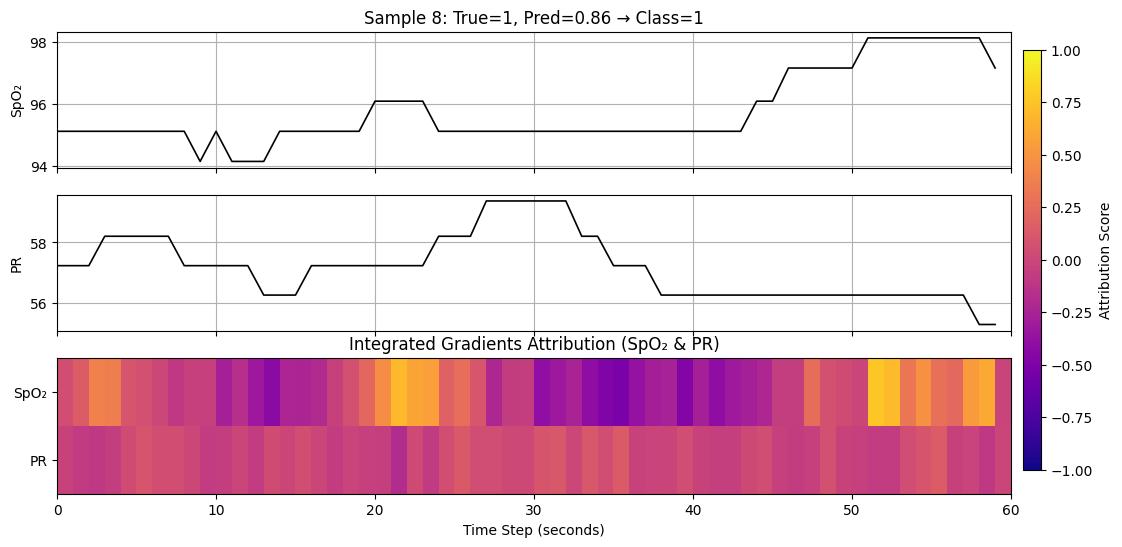

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


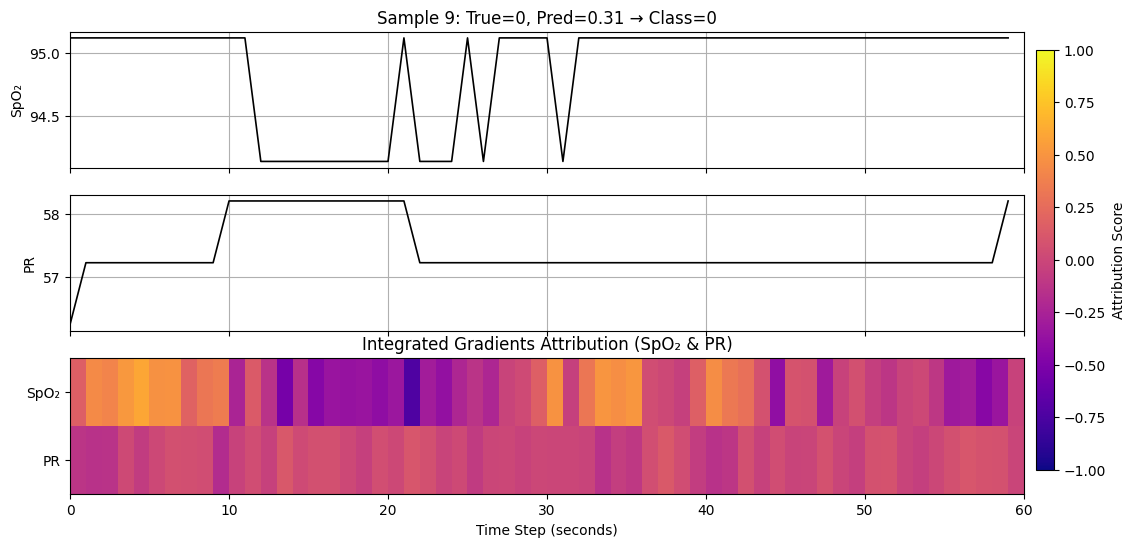

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


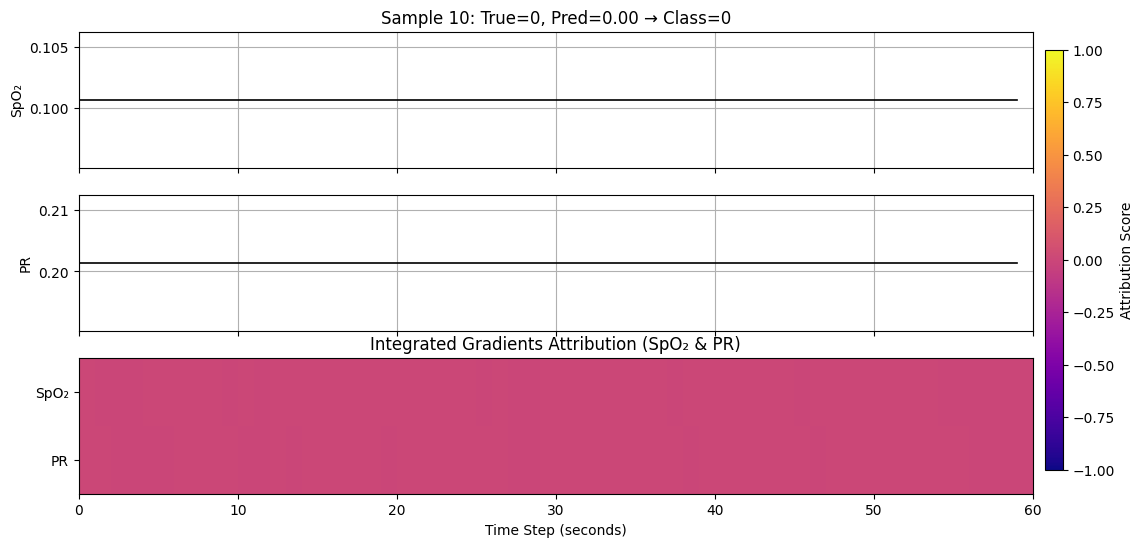

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


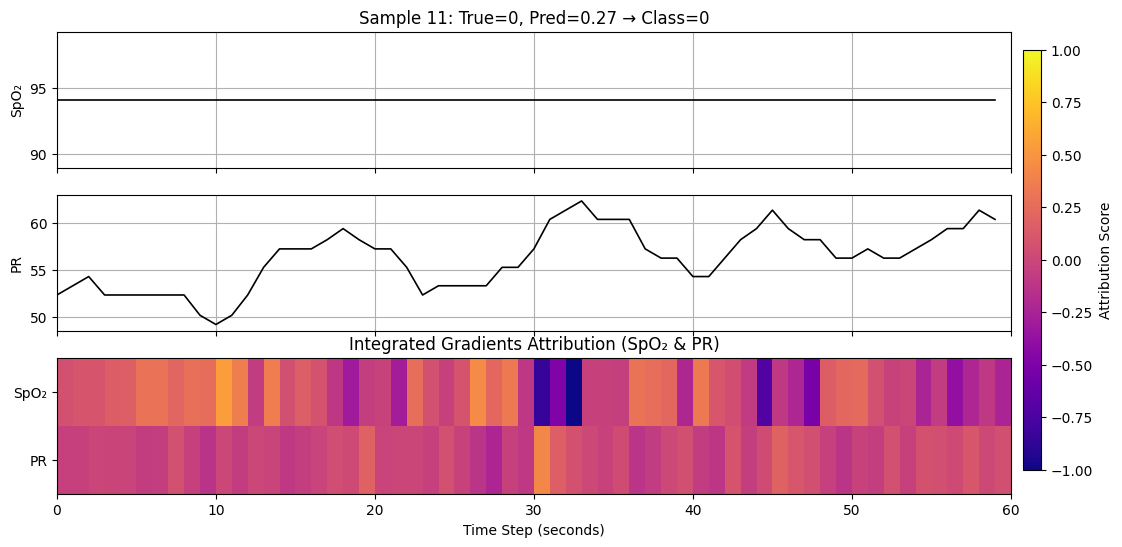

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


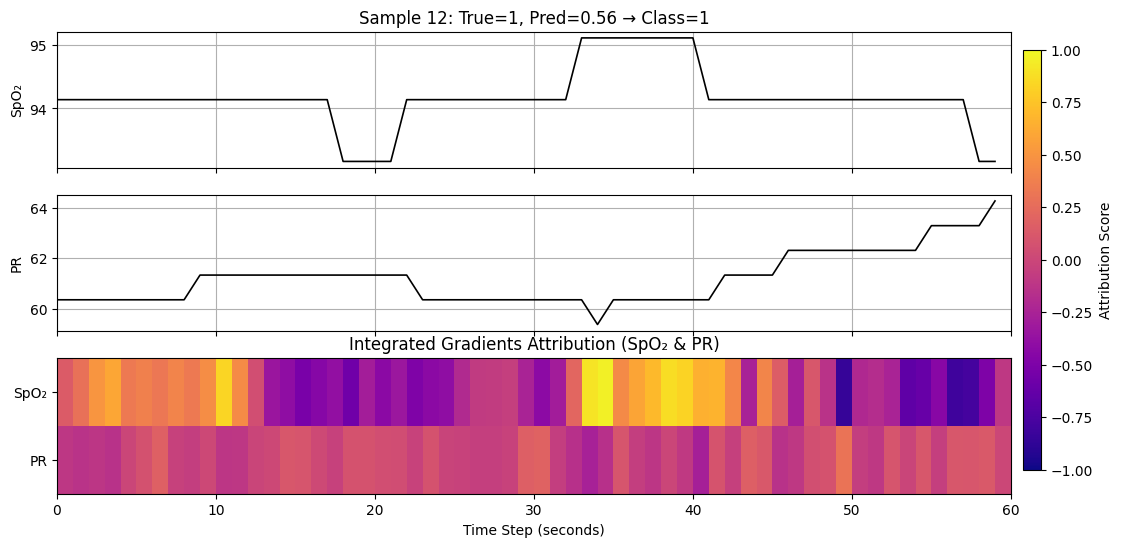

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


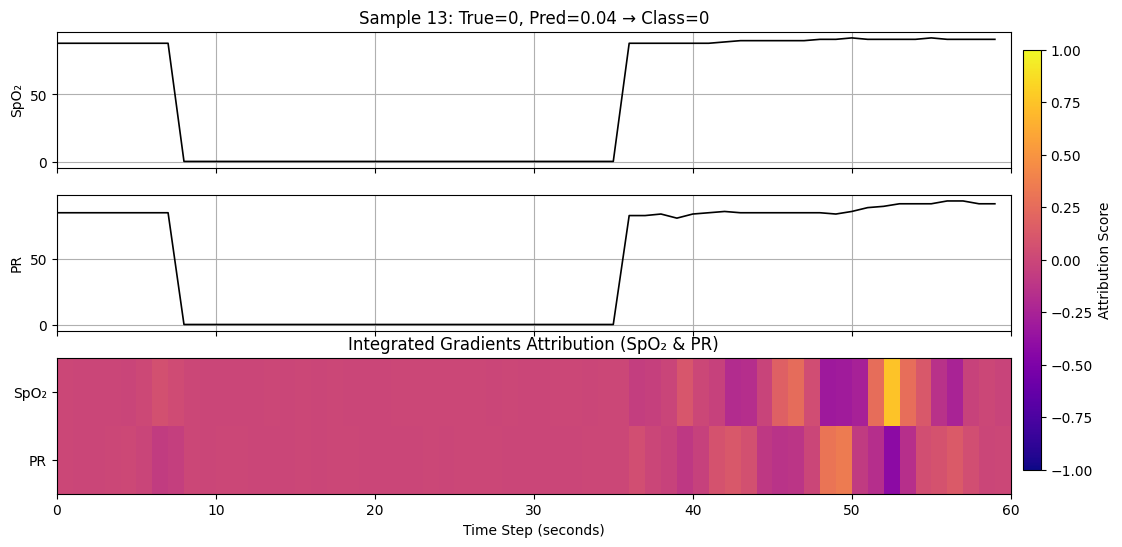

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


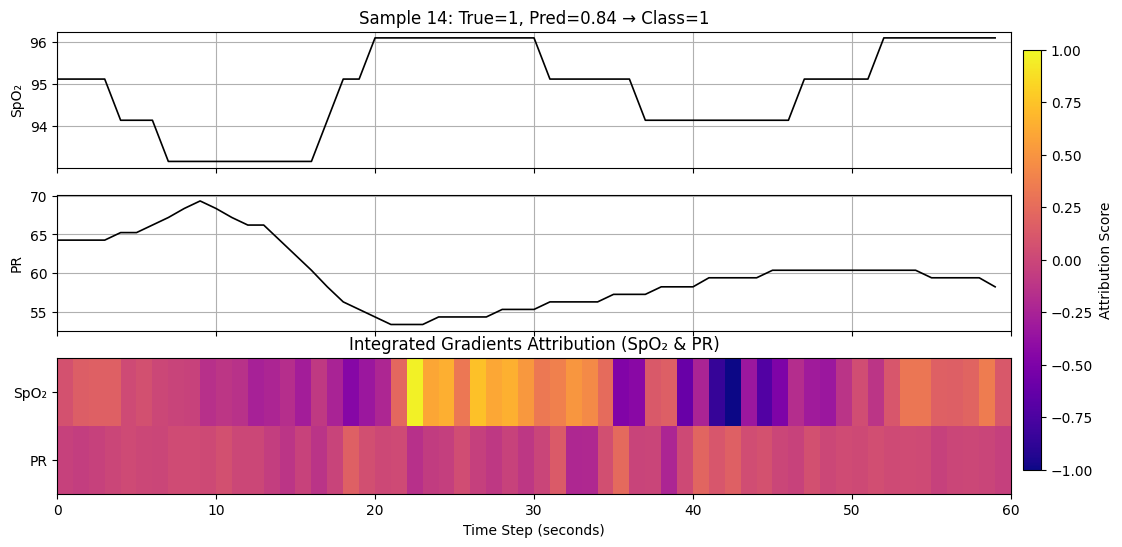

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


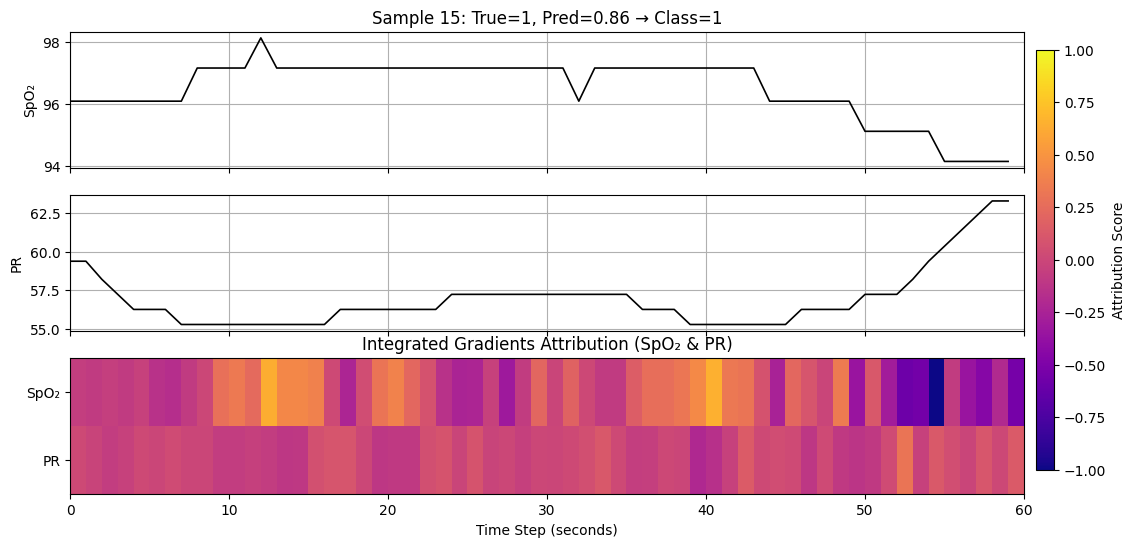

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


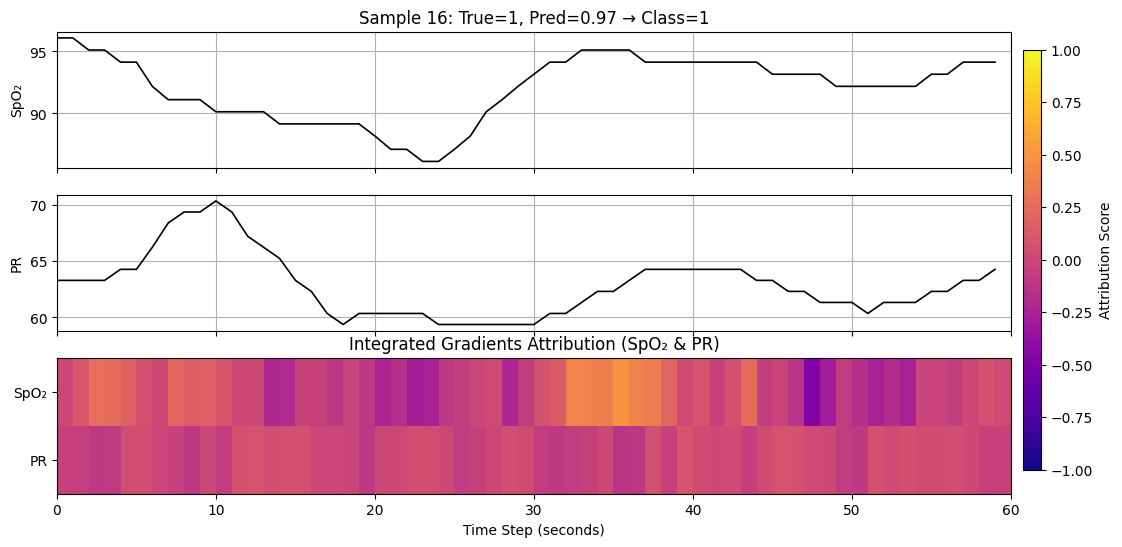

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


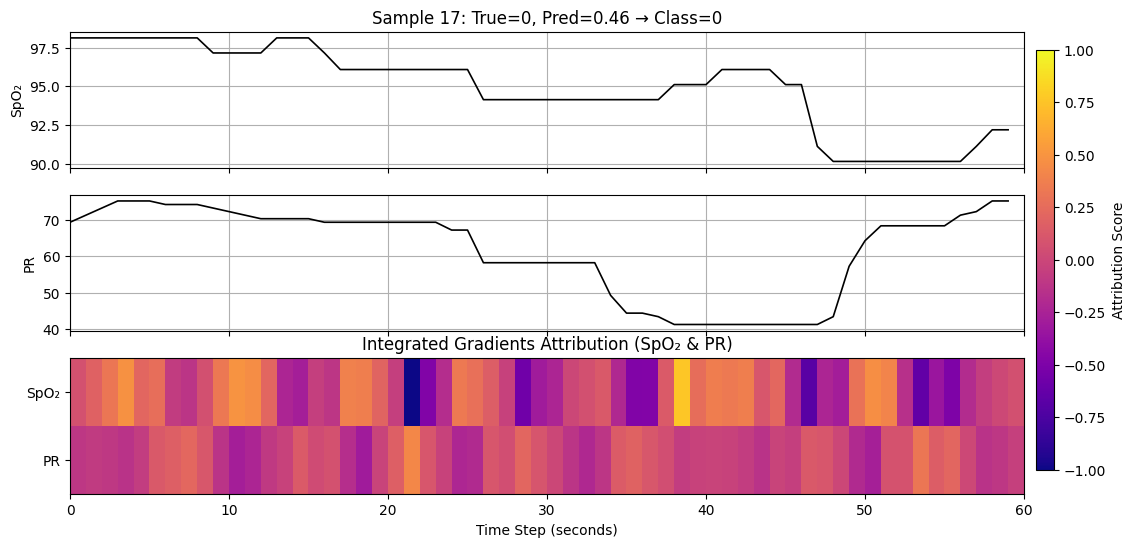

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


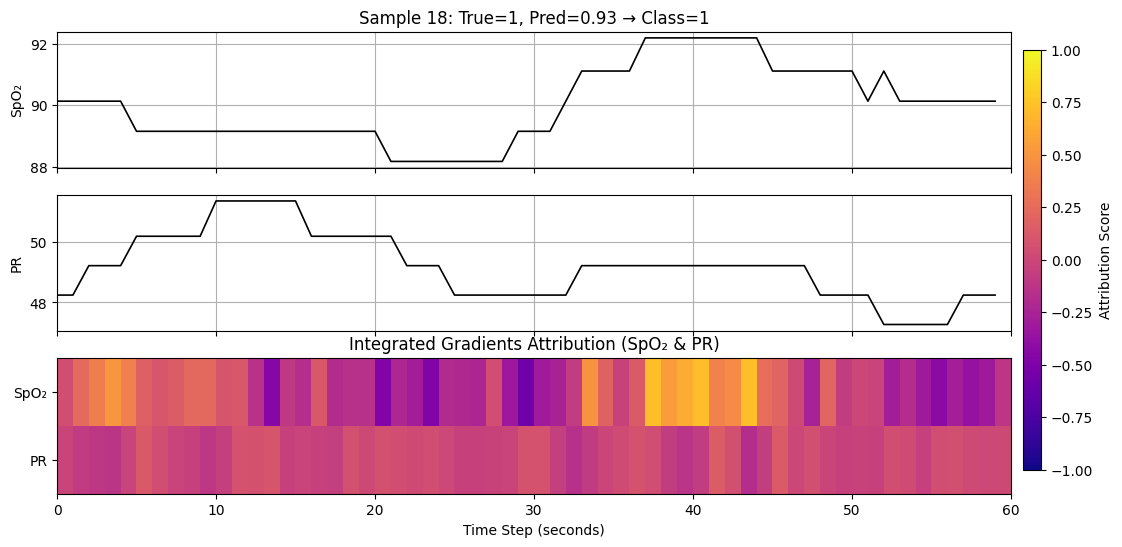

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


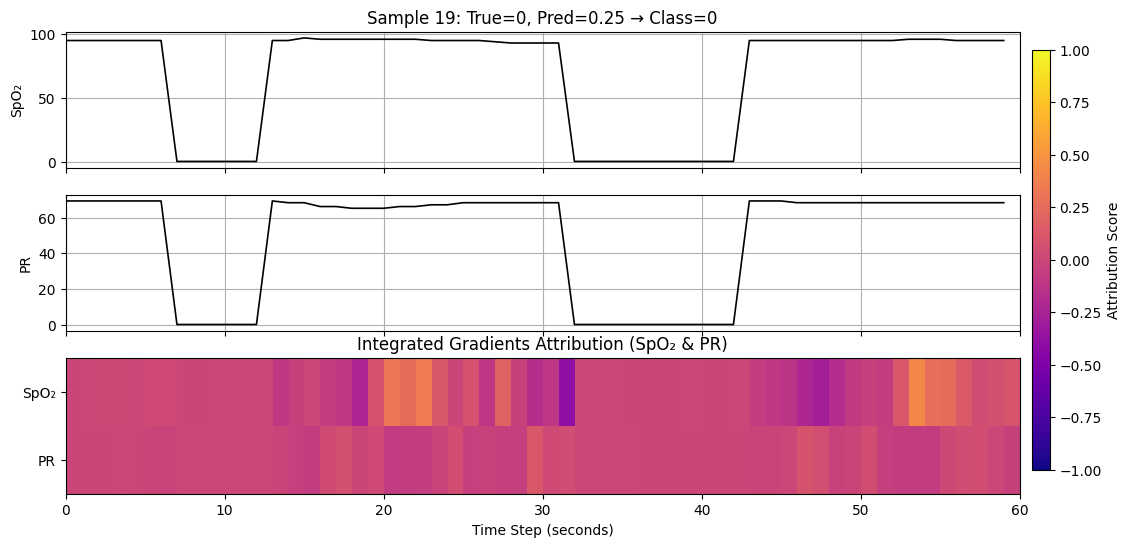

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


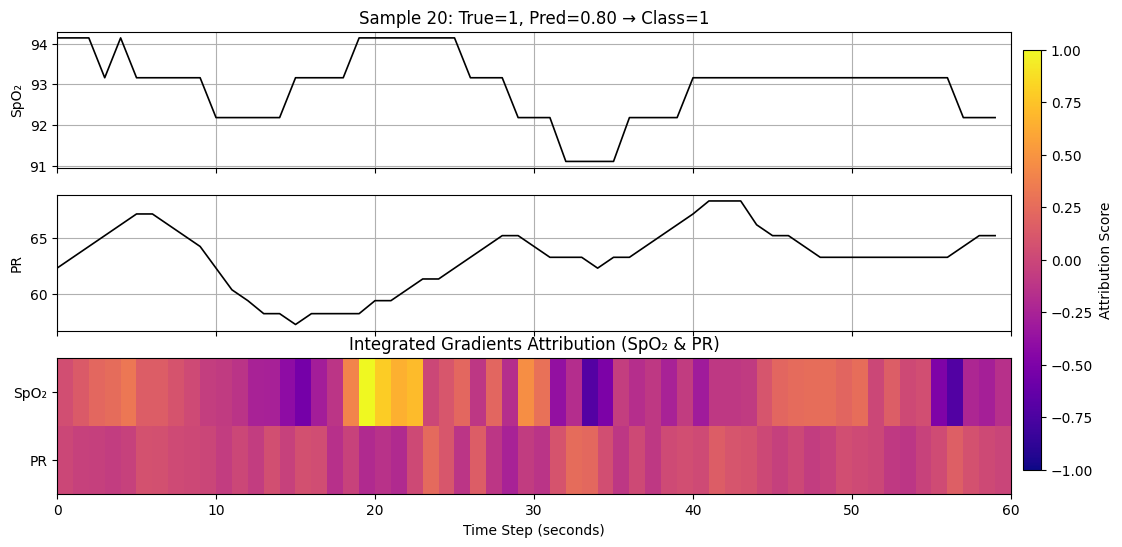

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


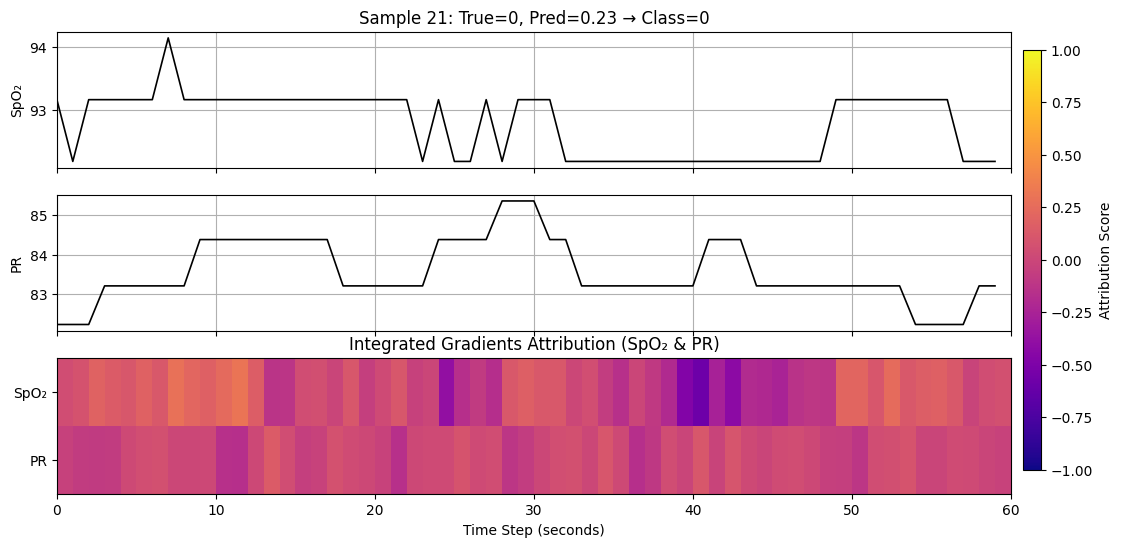

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


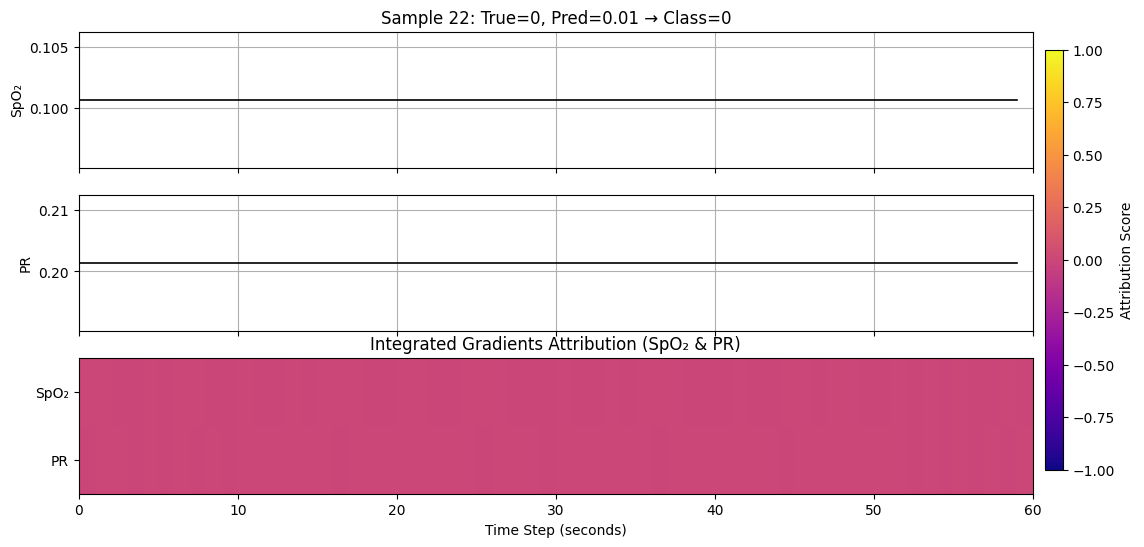

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


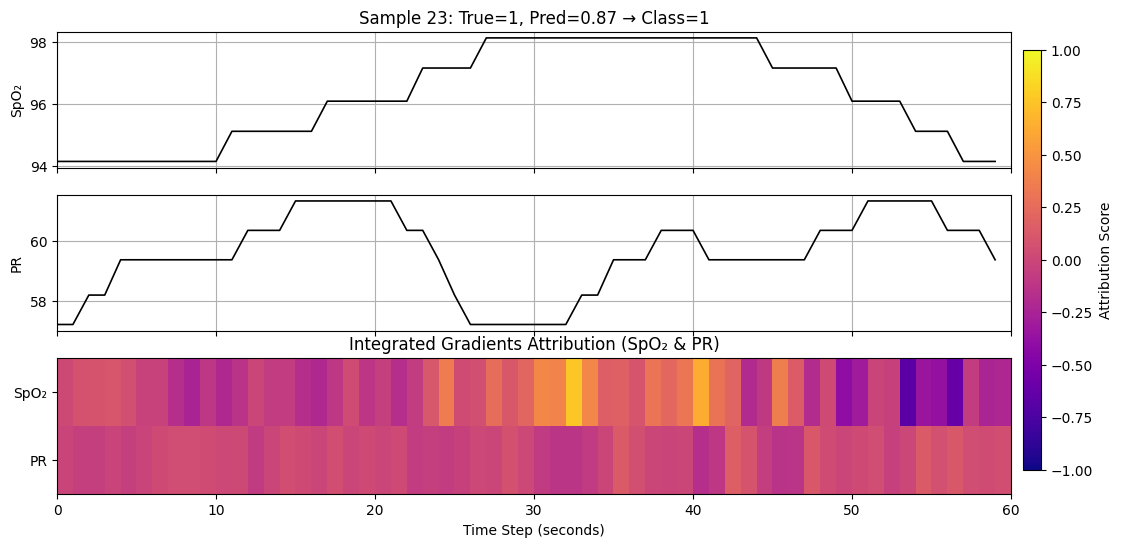

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


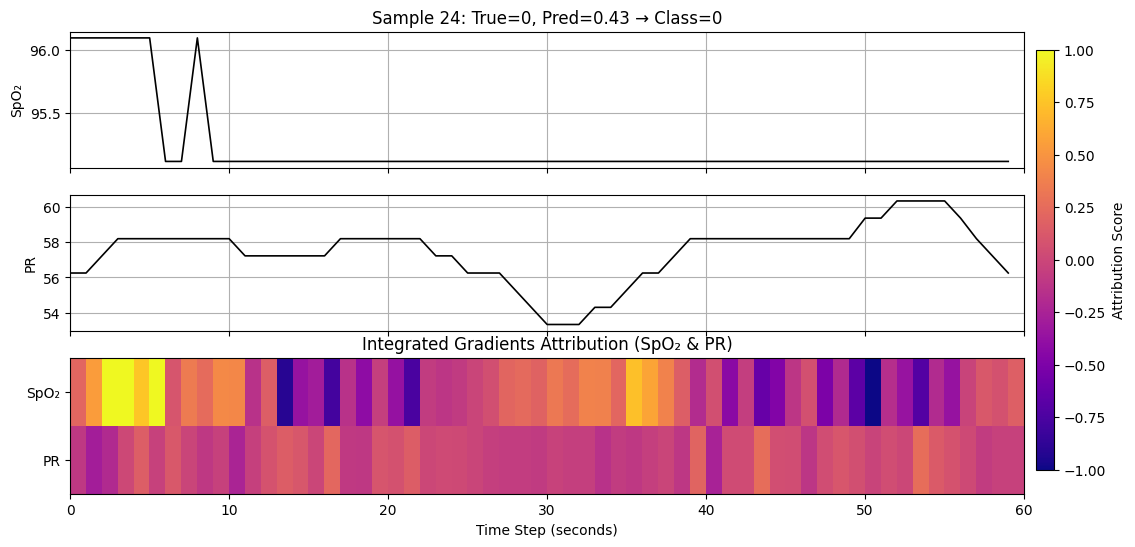

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


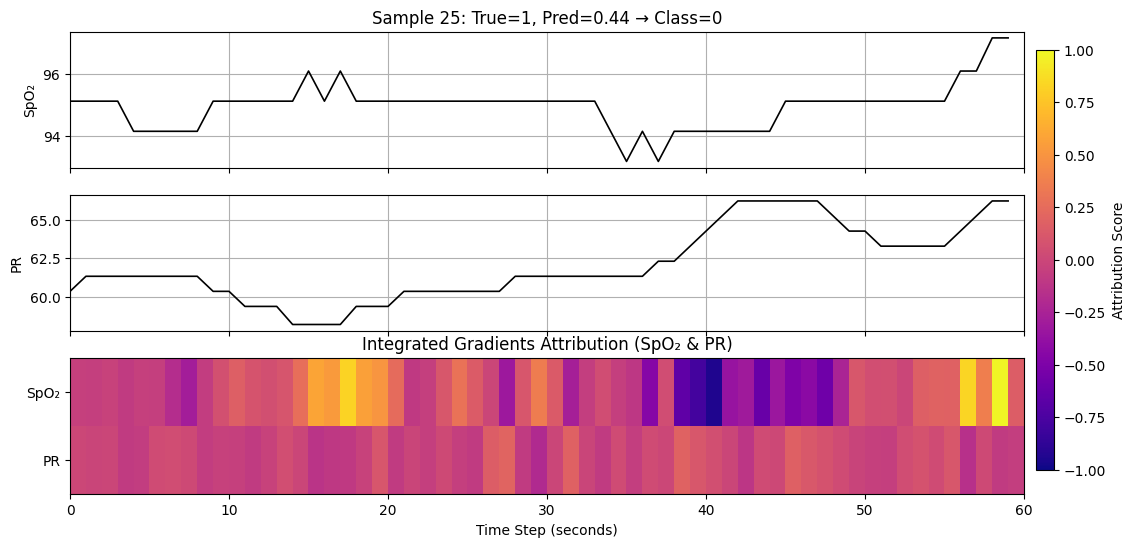

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


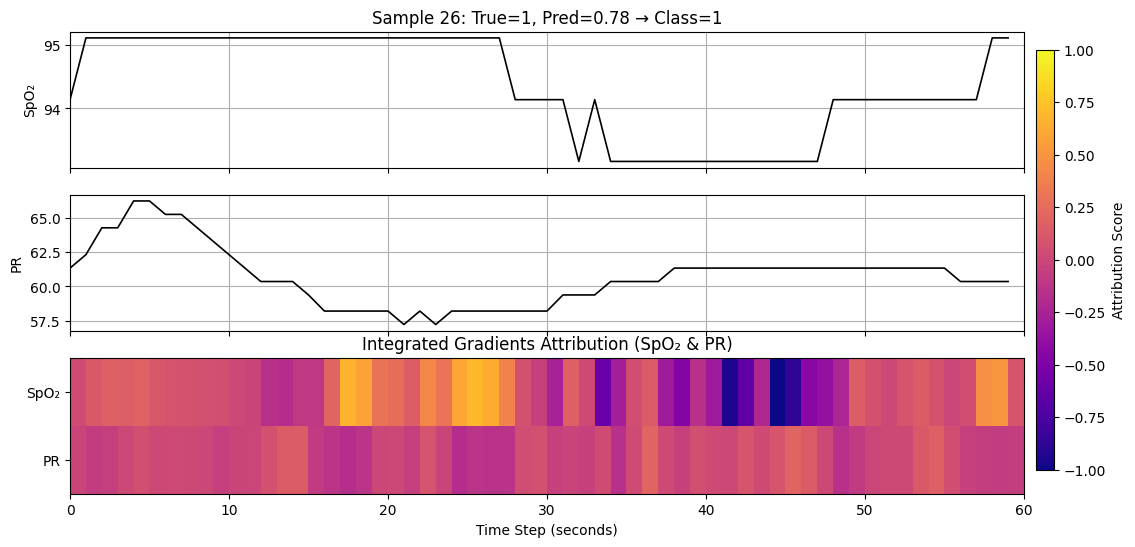

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


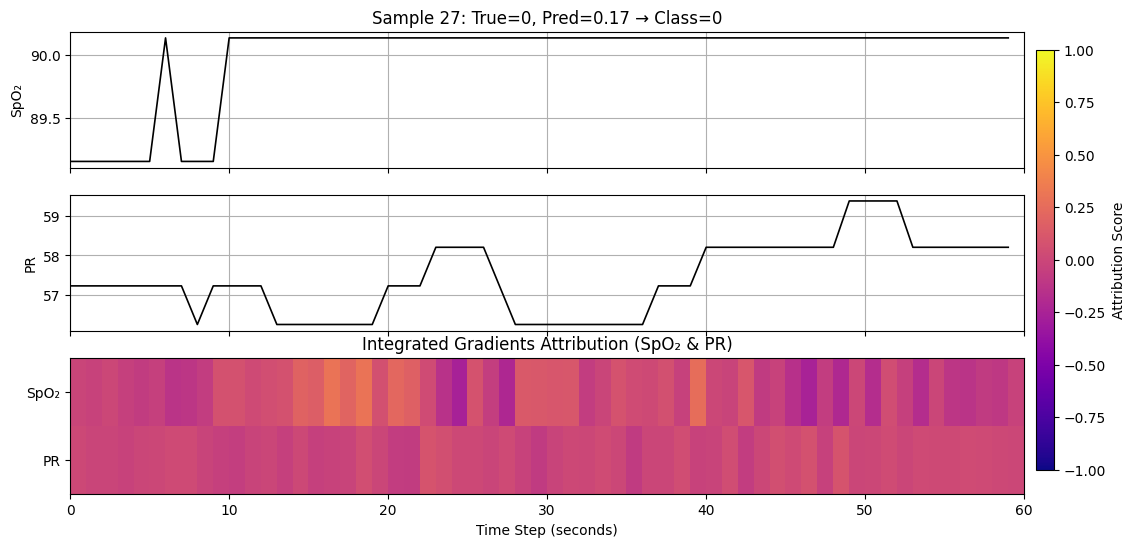

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


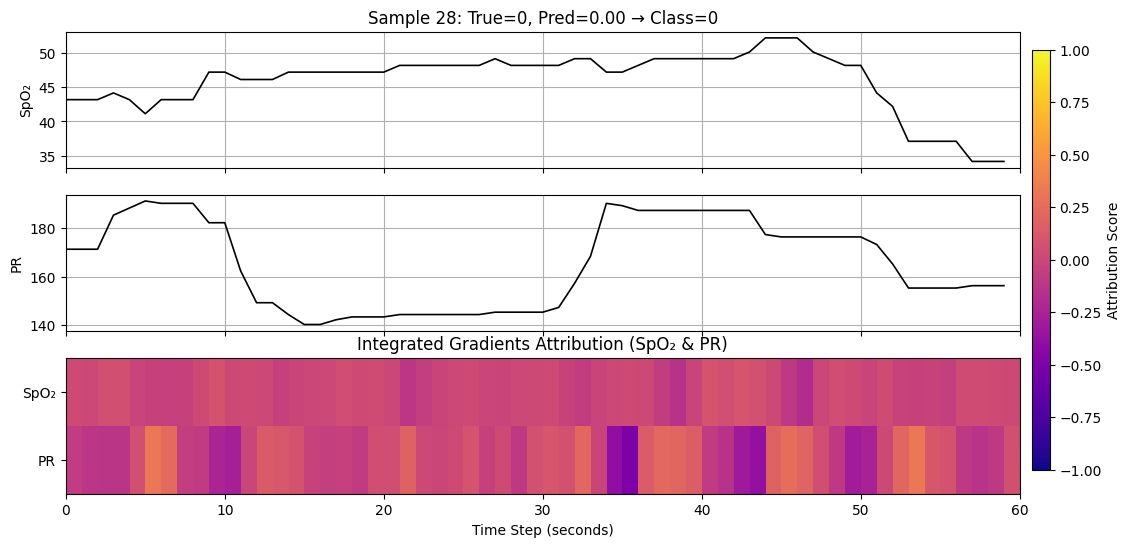

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


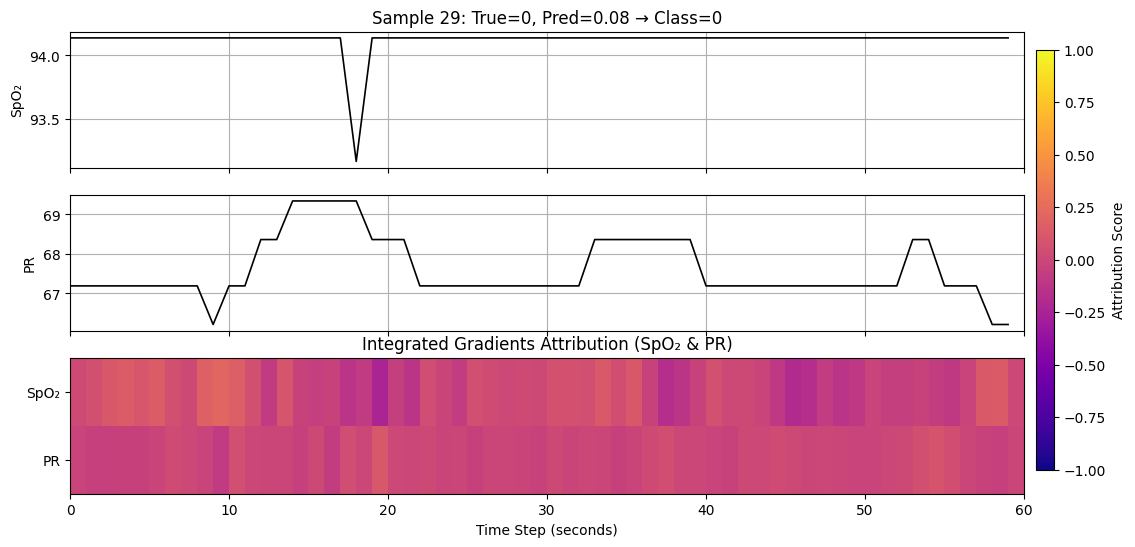

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


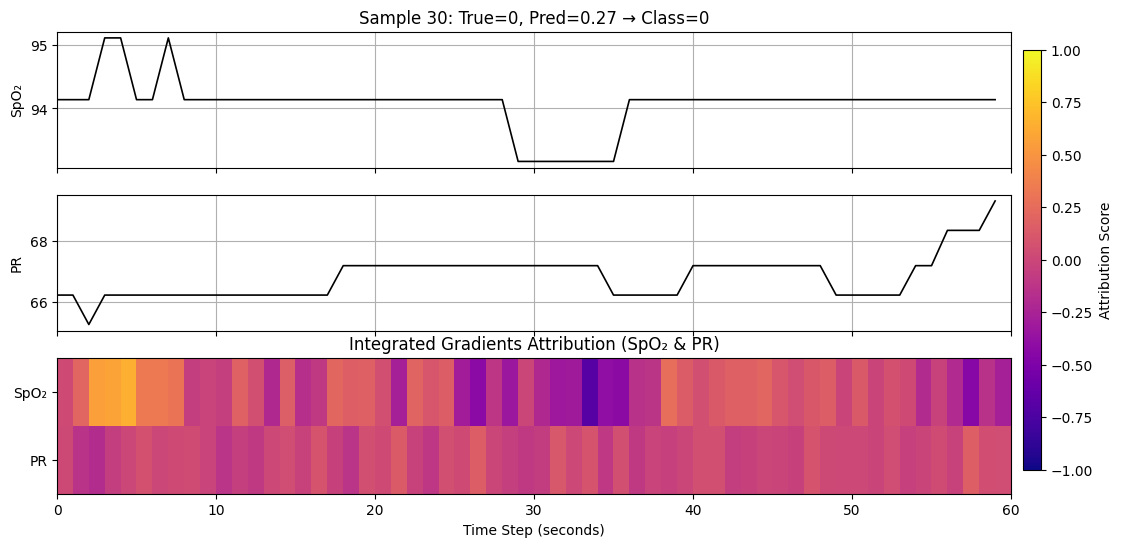

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


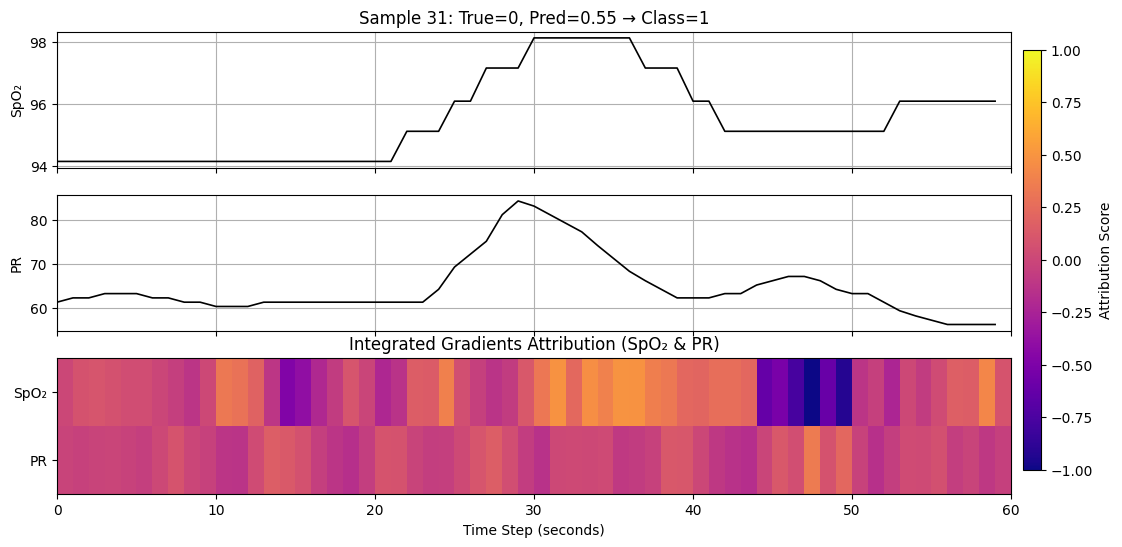

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


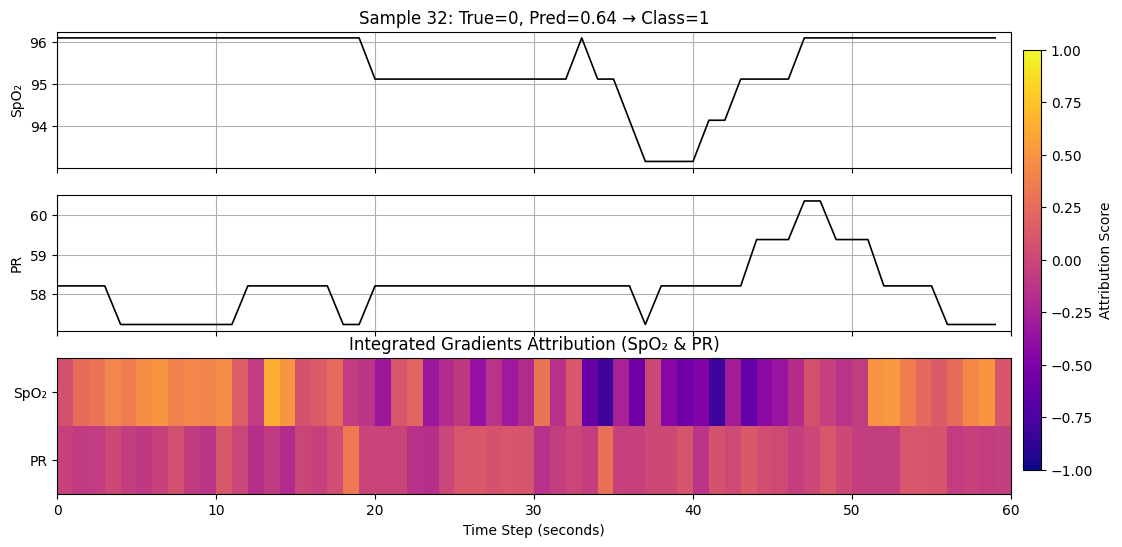

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


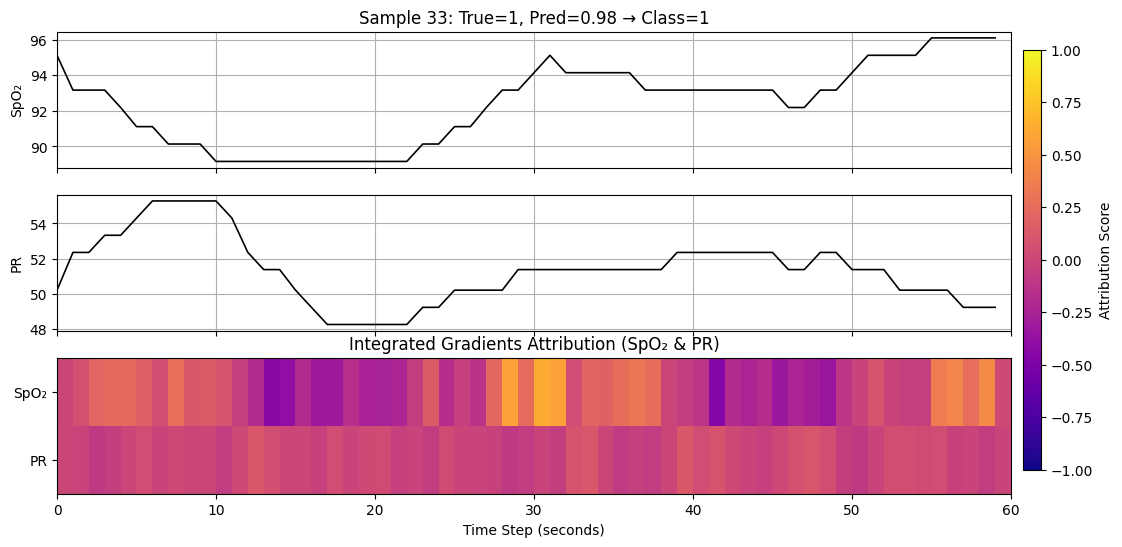

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


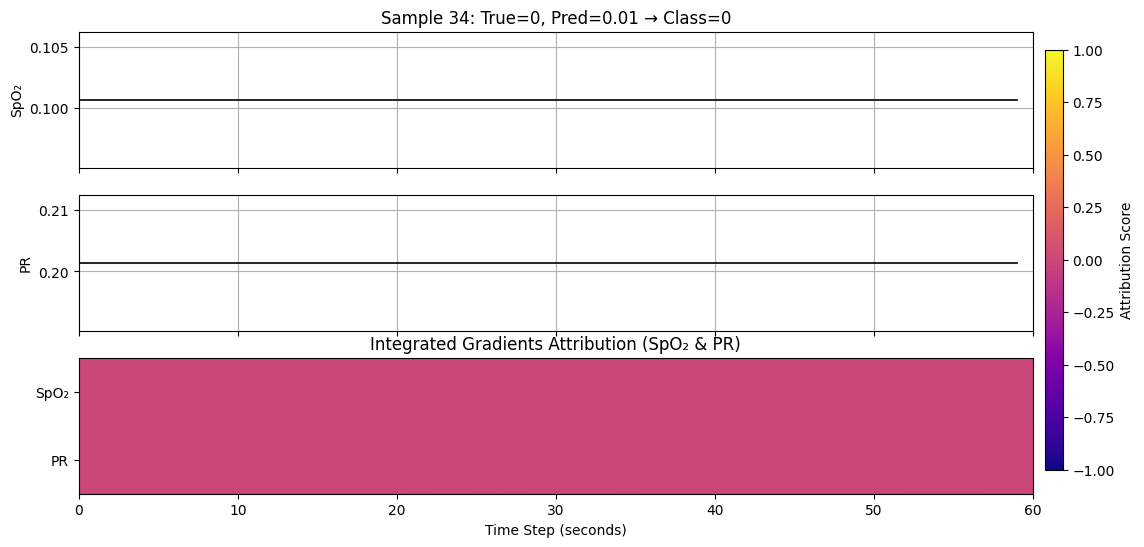

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


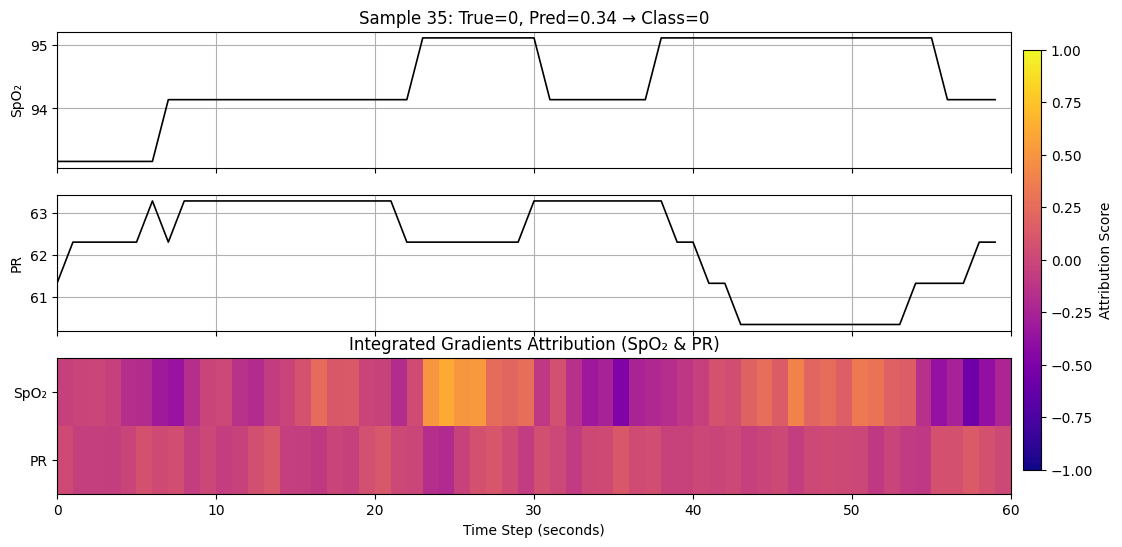

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


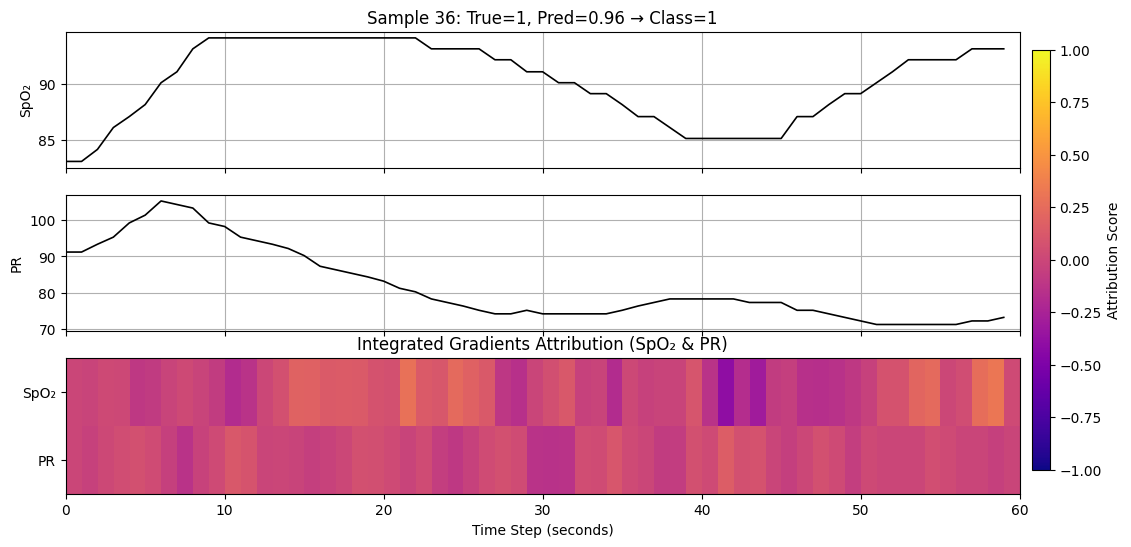

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


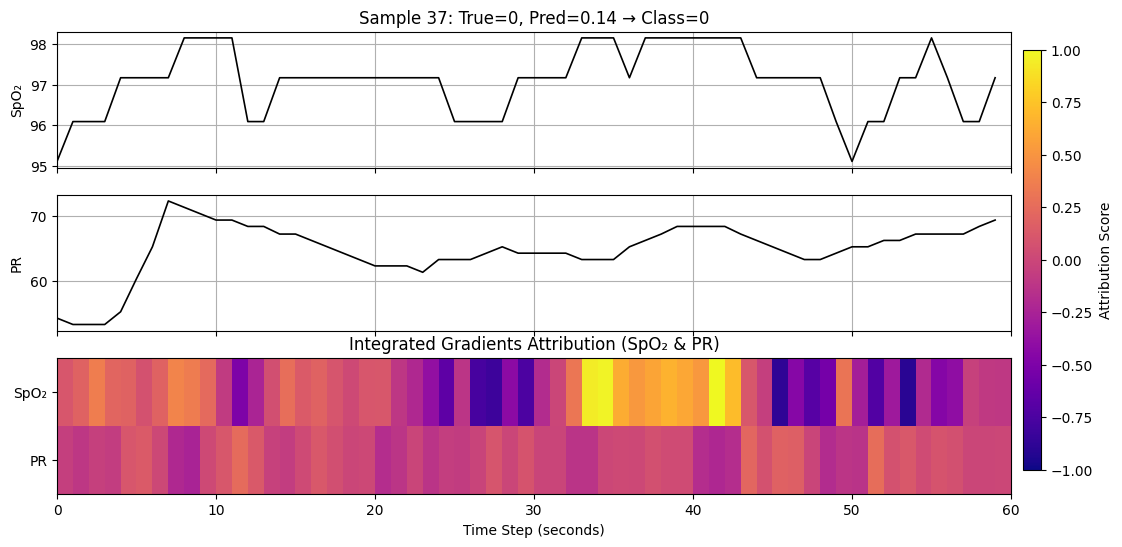

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


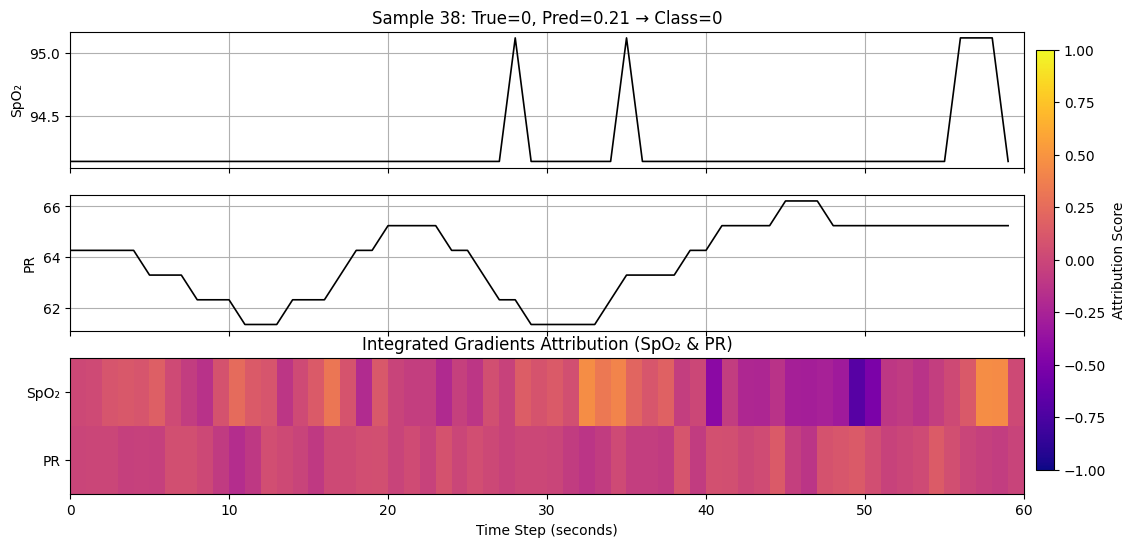

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


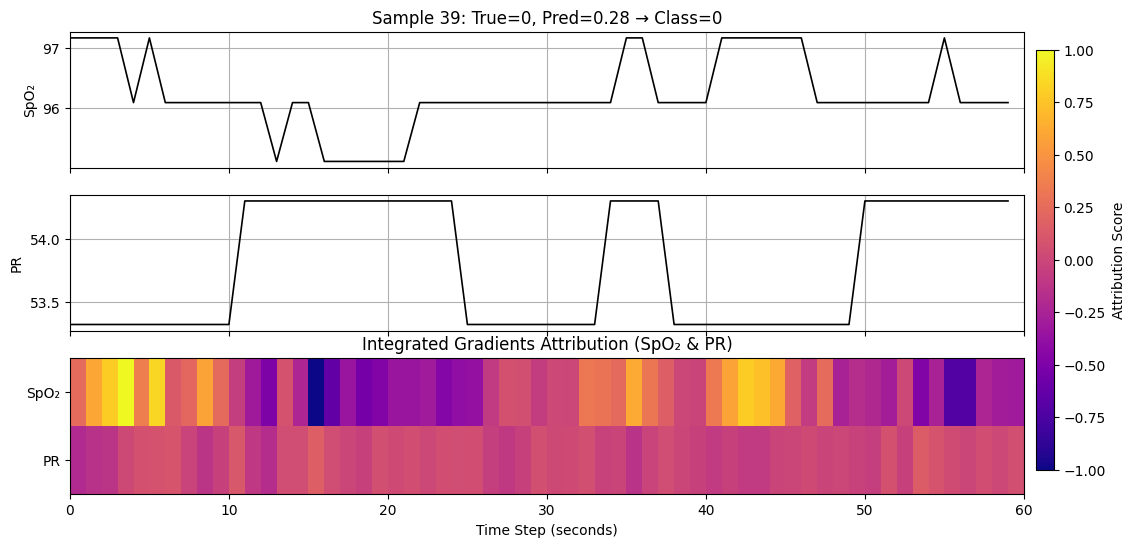

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


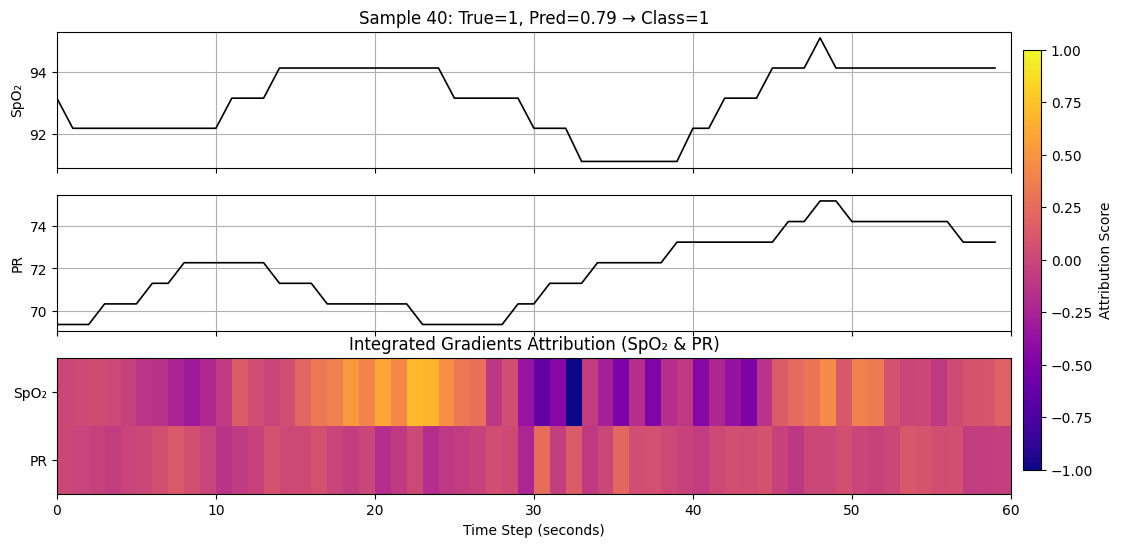

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


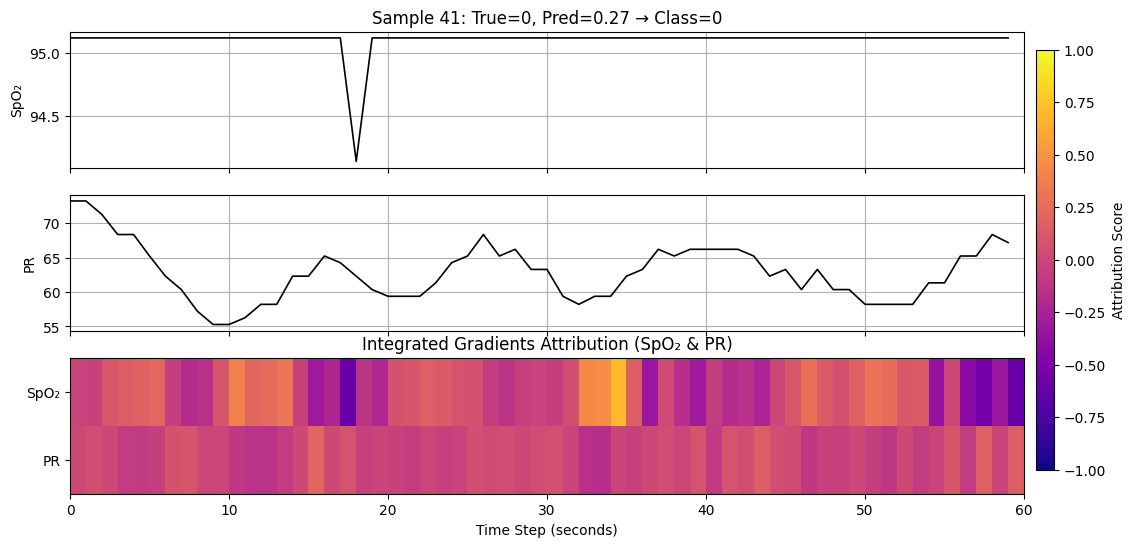

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


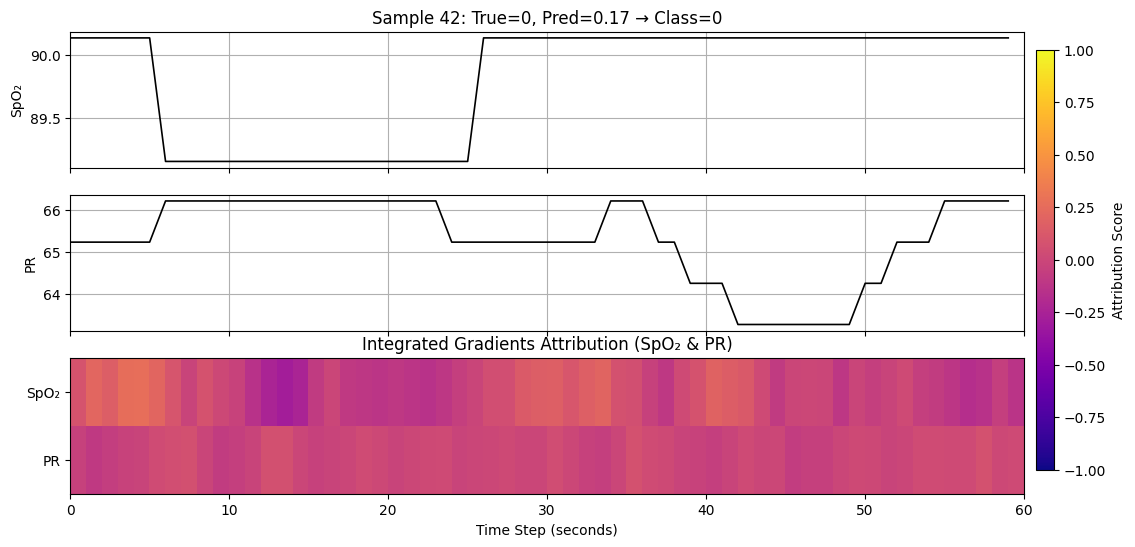

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


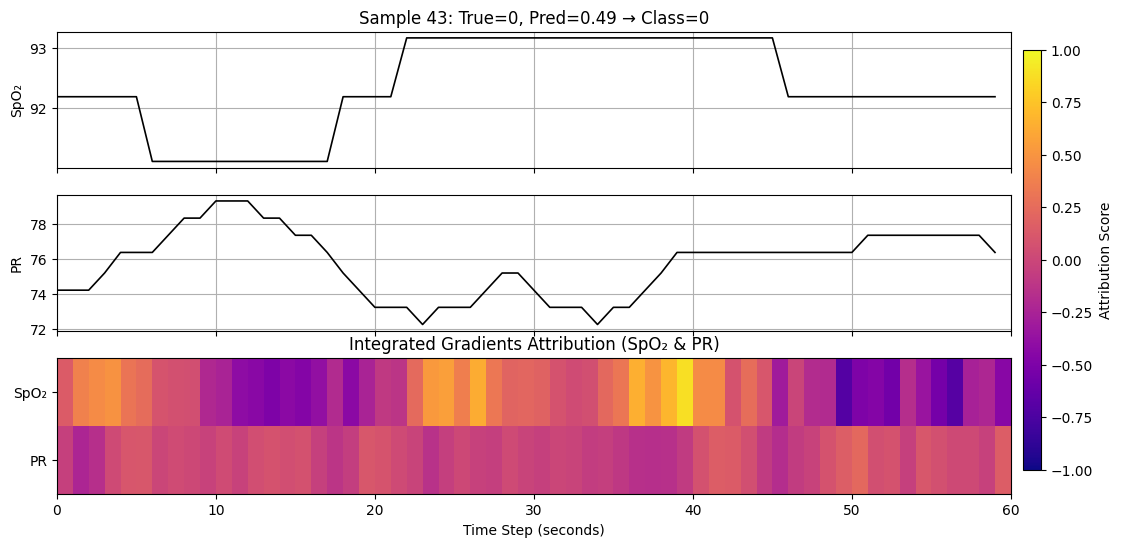

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


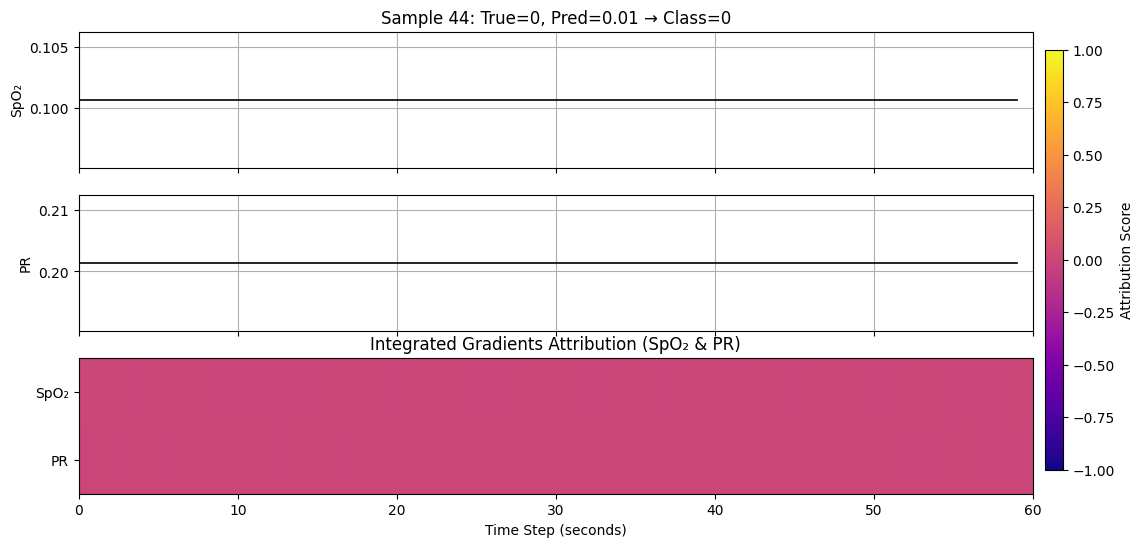

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


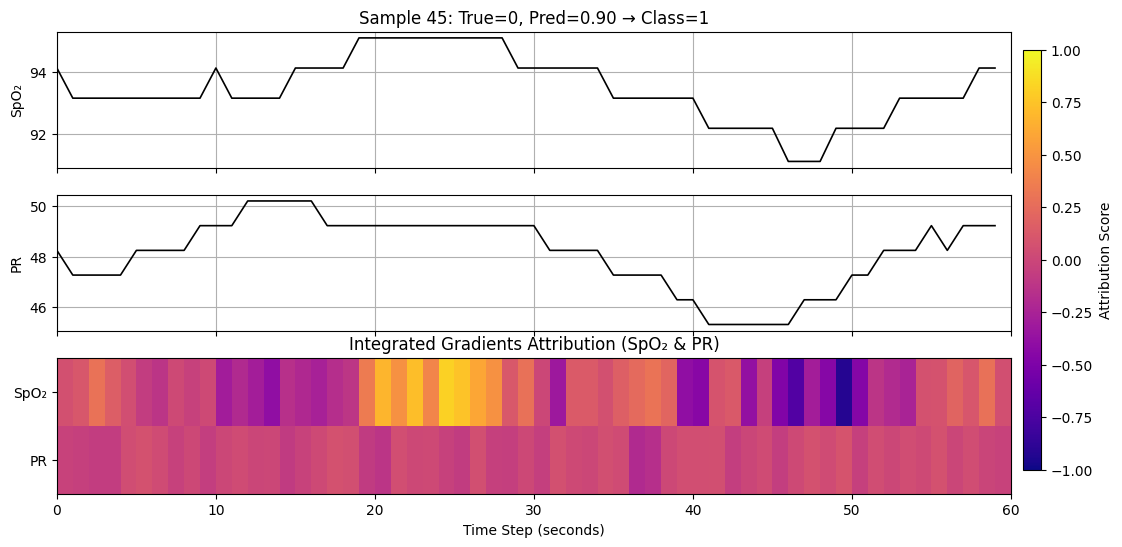

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


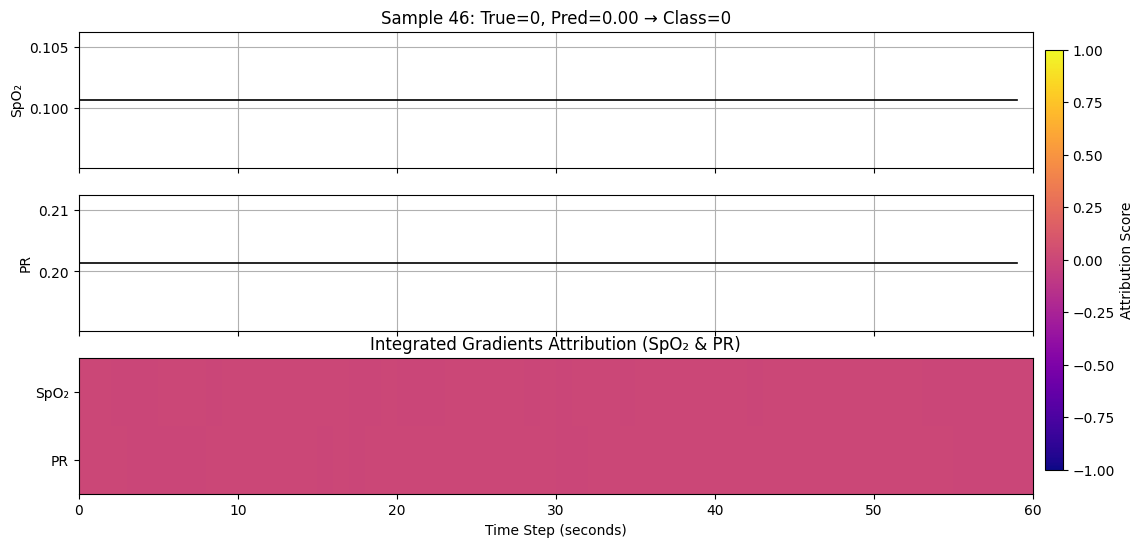

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


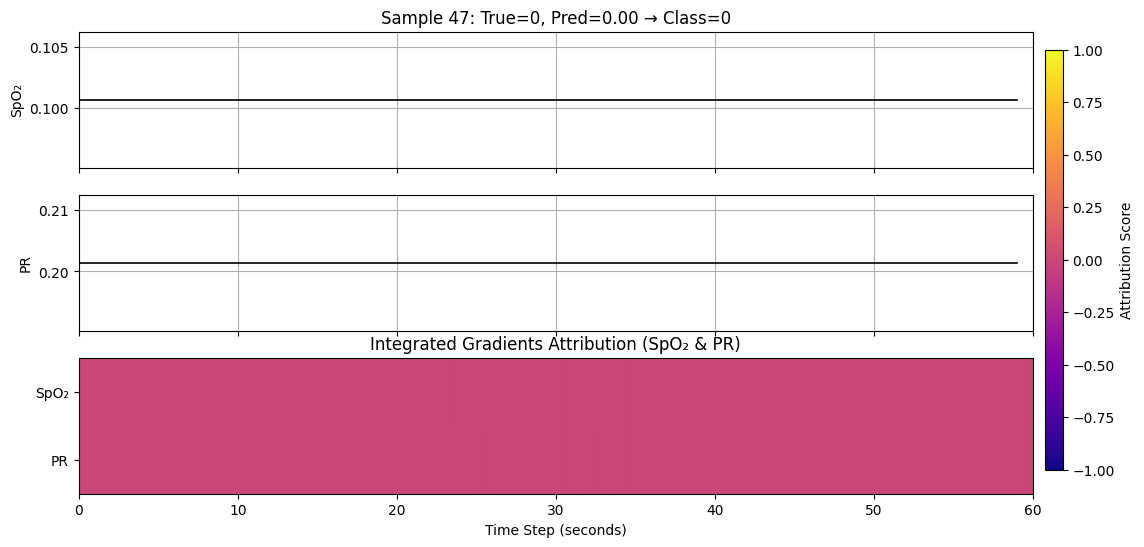

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


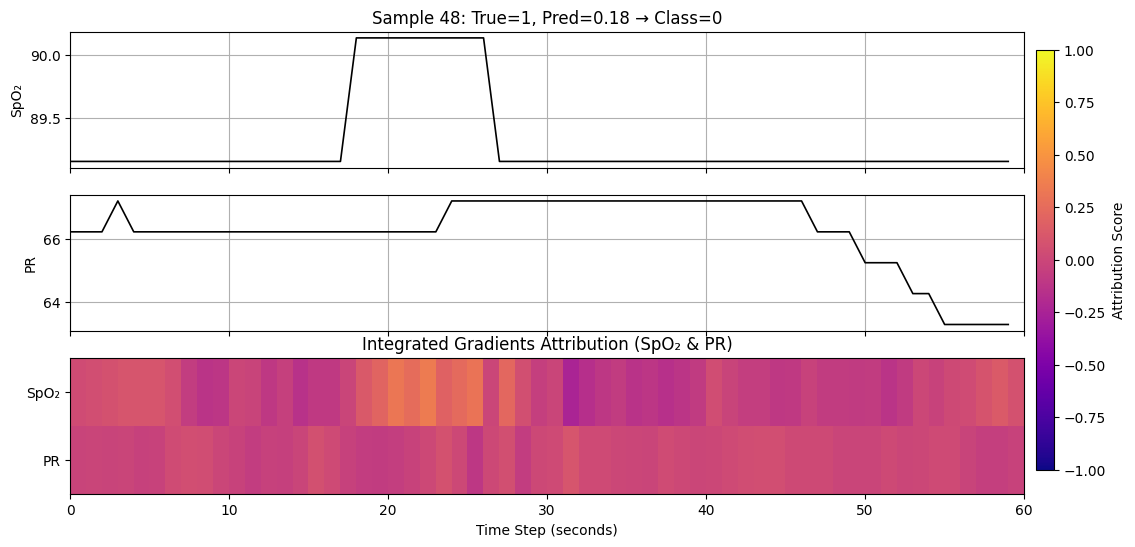

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


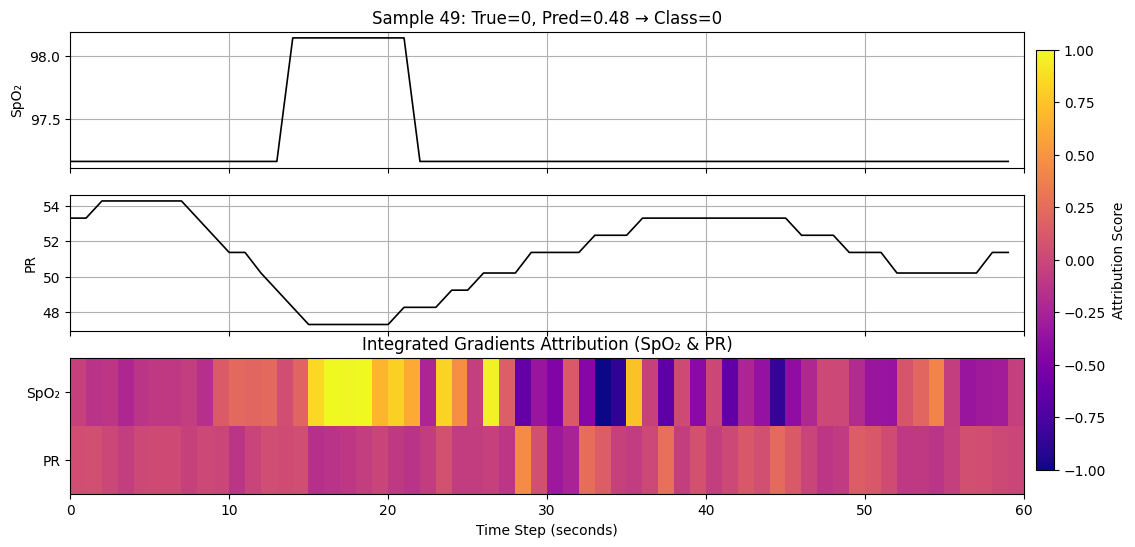

/tmp/ipykernel_7869/3444544588.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


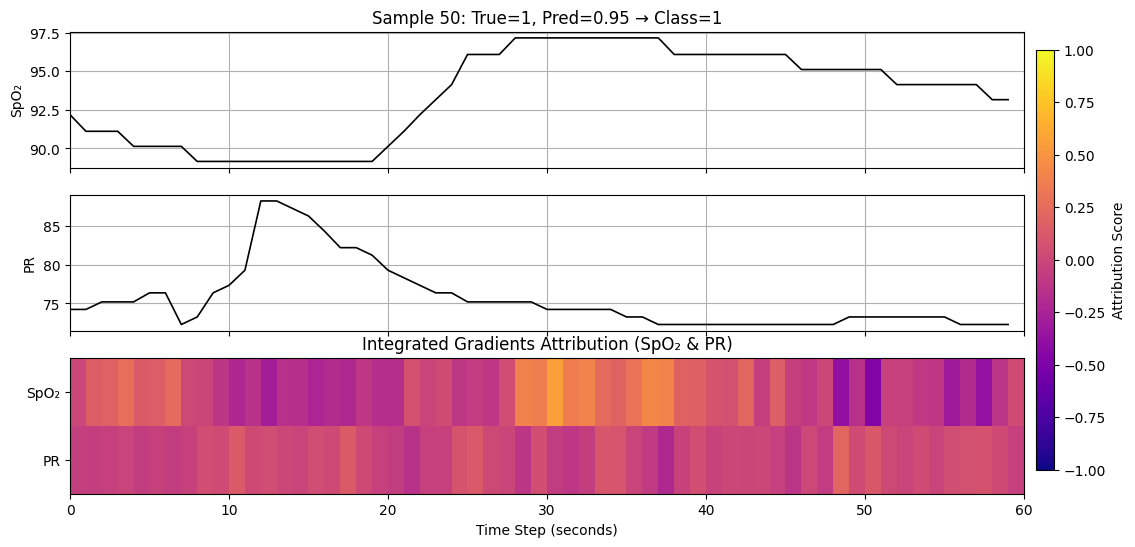

In [250]:
channel_names = ['SpO₂', 'PR']
vmin, vmax = -1, 1  # Color scale for attributions
time = np.arange(X_sample.shape[1])

for i in range(len(X_sample)):
    x = X_sample[i:i+1]
    true_label = y_sample[i]
    pred_prob = y_pred_probs[i]
    pred_class = y_pred_classes[i]

    # Compute IG attributions
    baseline = np.zeros_like(x)
    attributions = integrated_gradients(model, baseline, x, steps=50)

    # Extract relevant signals and attributions for channels 0 (SpO₂) and 1 (PR)
    spo2_signal = x[0, :, 0]
    pr_signal = x[0, :, 1]
    spo2_attr = attributions[:, 0]
    pr_attr = attributions[:, 1]

    # Plot signals and heatmap
    fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True, 
                             gridspec_kw={'height_ratios': [1, 1, 1], 'right': 0.92})

    # SpO₂
    axes[0].plot(time, spo2_signal, color='black', linewidth=1.2)
    axes[0].set_ylabel("SpO₂", fontsize=10)
    axes[0].set_title(f"Sample {i+1}: True={true_label}, Pred={pred_prob:.2f} → Class={pred_class}", fontsize=12)
    axes[0].grid(True)

    # PR
    axes[1].plot(time, pr_signal, color='black', linewidth=1.2)
    axes[1].set_ylabel("PR", fontsize=10)
    axes[1].grid(True)

    # IG heatmap for SpO₂ and PR
    heatmap = np.stack([spo2_attr, pr_attr], axis=0)
    im = axes[2].imshow(
        heatmap,
        aspect='auto',
        cmap='plasma',
        interpolation='nearest',
        extent=[0, x.shape[1], 1.5, -0.5],
        vmin=vmin,
        vmax=vmax
    )
    axes[2].set_yticks([0, 1])
    axes[2].set_yticklabels(channel_names)
    axes[2].set_xlabel("Time Step (seconds)", fontsize=10)
    axes[2].set_title("Integrated Gradients Attribution (SpO₂ & PR)")

    # Add colorbar
    cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label("Attribution Score")

    plt.tight_layout()
    plt.show()


### Conclusion: Evaluation of the Model and Integrated Gradients Explanations

#### Model Behavior
The convolutional neural network (CNN) trained on multichannel physiological data (SpO₂, PR, thoracic and abdominal respiration) demonstrates strong performance in predicting sleep apnea, with **SpO₂ and PR channels emerging as dominant features**. Quantitative attribution analysis confirmed that these two signals received the highest integrated gradient scores in correctly predicted samples.

Visual inspection across multiple windows revealed that the model consistently identified **desaturation events in SpO₂** and **autonomic changes in PR** as core indicators of apneic episodes. This aligns with established clinical knowledge, where oxygen desaturation and heart rate variability reflect apneic burden and compensatory mechanisms.

However, the model **largely ignores thoracic and abdominal respiratory channels**, even in cases where visible abnormalities are present. This may indicate issues with signal-to-noise ratio in these channels or suggest that the model has overfitted to the SpO₂ and PR features due to their higher signal consistency.

#### ⚠️ Unexpected Attribution: Yellow During SpO₂ Recovery
An interesting observation in several attribution maps is that **positive attributions (yellow)** appear not only during drops in SpO₂, but also during **SpO₂ recovery phases** — when saturation is increasing. This behavior may seem counterintuitive, as rising SpO₂ is typically associated with the **end of an apnea event** rather than its onset.

Possible explanations for this include:

- **Temporal association bias**: The model may have learned to associate **entire desaturation-recovery patterns** with apnea, attributing predictive importance to the recovery as part of the broader apnea event structure.
- **Boundary sensitivity**: In some training examples, the label may be applied to the full desaturation event including the recovery segment, leading the model to treat rising SpO₂ as a feature of apnea windows.
- **Rebound prediction**: The **recovery slope or overshoot** in SpO₂ may itself be a learned feature, especially in severe apneas where compensatory responses are exaggerated.
- **Lack of fine temporal labeling**: Because the window-level labeling is binary (apnea/no-apnea), the model is not explicitly trained to distinguish sub-epochs (onset, nadir, recovery), leading to blurred attributions across the full event.

This finding illustrates a key limitation of coarse labeling in temporal tasks and highlights the need for **more granular temporal annotations** or **sequence models** that can learn phase-specific dynamics.

#### Explanation Reliability: Integrated Gradients
Integrated Gradients (IG) produced consistent and interpretable attribution maps:
- In **true positives**, attributions aligned with meaningful SpO₂ and PR changes.
- In **true negatives**, low attribution across all channels indicated model certainty.
- In **false positives**, some IG heatmaps highlighted segments with no clinical relevance, which likely reflects overfitting or bias in the model’s internal representations.

Despite these limitations, IG clearly surfaces the **internal decision logic of the model** and provides a powerful tool for debugging and clinical validation.

#### Overall Assessment
The model exhibits **clinically aligned predictive behavior** and Integrated Gradients enables **transparent post-hoc inspection**. However, current explanations also expose vulnerabilities:
- Overreliance on SpO₂,
- Limited use of respiration channels,
- Misinterpretation of recovery dynamics as predictors.

To improve robustness and interpretability:
- Incorporate temporally resolved labels or sequential modeling (e.g., LSTMs, transformers).
- Use explainability-aware training (e.g., attention constraints, regularization).
- Validate attributions with clinician-annotated signal features.

This study underscores the value of explainability in medical AI, while also cautioning against overinterpreting model behavior without deeper physiological grounding.
